# Inference: Simple-Importance-Sampling MCMC

The class below takes a posterior and forms another by raising it to a power (1 minus temperature).

In [1]:
import os
os.chdir("..")
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc

class TemperedLogPosterior(pints.LogPDF):
    def __init__(self, temperature, log_posterior):
        self._temperature = temperature
        self._log_posterior = log_posterior
        
    def __call__(self, x):
        return (1.0 - self._temperature) * self._log_posterior(x)

    def n_parameters(self):
        return self._log_posterior.n_parameters()
def ess(w):
    return int(1.0 / np.sum(w**2))

# Goodwin oscillator

### Untempered

[ 2.    4.    0.12  0.08  0.1 ]
Running
Done!


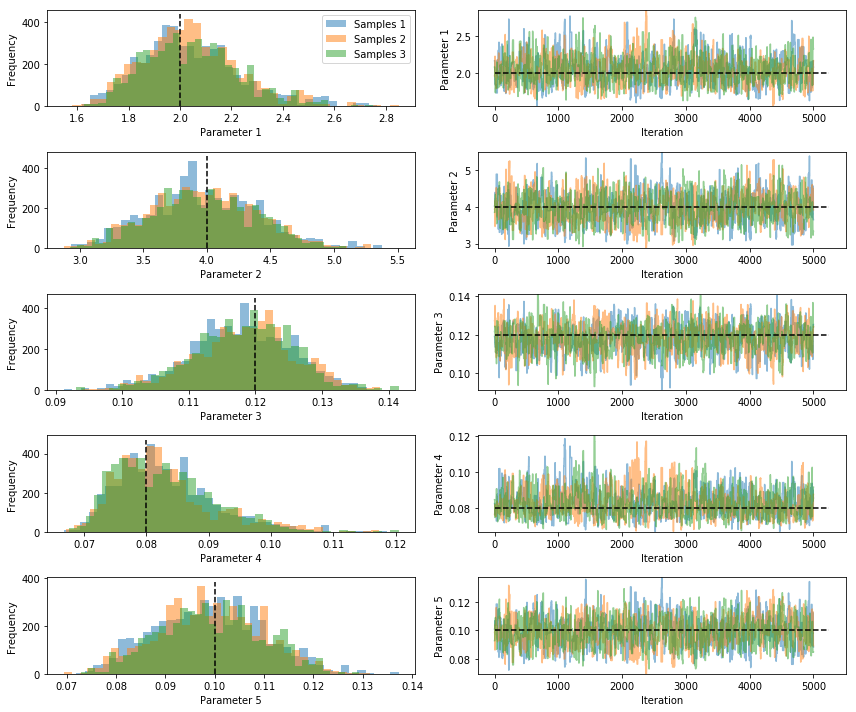

In [19]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = np.linspace(0, 100, 20)
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.0
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 5000:, :]

# Get samples
samples=np.vstack(chains)

plt.figure()
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

In [20]:
print('R-hat:')
print(pints.rhat_all_params(chains))
pints.effective_sample_size(np.vstack(chains))

R-hat:
[1.0000215300580149, 0.99993152776227368, 1.0013194051338465, 1.0003139413911111, 0.99995283031150495]


[678.78288452969571,
 646.35671704453614,
 677.54232953566327,
 643.43450526758841,
 697.23591349823744]

### Tempered at T=0.5

[ 2.    4.    0.12  0.08  0.1 ]
Running
Done!


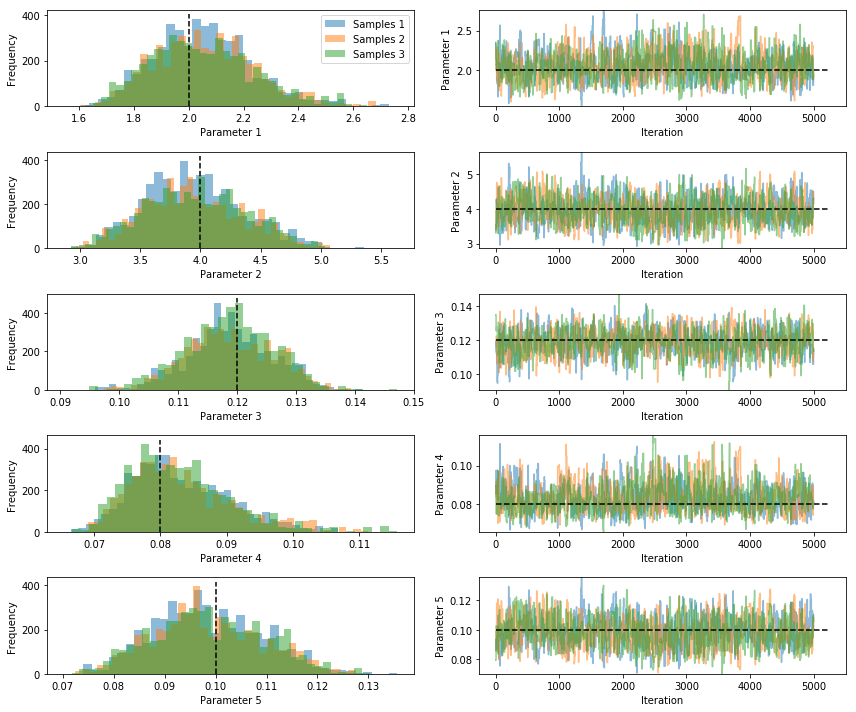

ESS = 256


In [21]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.9
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 5000:, :]

plt.figure()
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

# Get samples
samples=np.vstack(chains)

log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))
print('ESS = ' + str(ess(w)))
idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

In [24]:
print('R-hat:')
print(pints.rhat_all_params(chains))

print(ess(w) / len(w))

R-hat:
[1.0006128275041417, 1.0001972258830019, 0.99997786473559258, 1.000248521147354, 1.0001026685673735]
0.017066666666666667


# Repressilator

### Untempered

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.1
2     9      0         0.333     0          0:00.1
3     12     0.25      0.25      0.25       0:00.1
20    63     0.143     0.143     0.333      0:00.5
40    123    0.195122  0.122     0.366      0:01.0
60    183    0.23      0.115     0.279      0:01.5
80    243    0.284     0.148     0.259      0:01.8
100   303    0.248     0.168     0.257      0:02.2
120   363    0.214876  0.174     0.231405   0:02.6
140   423    0.191     0.163     0.22       0:03.0
160   483    0.18      0.155     0.224      0:03.5
180   543    0.160221  0.144     0.215      0:03.9
Initial phase completed.
200   603    0.164     0.129     0.204      0:04.3
220   663    0.172     0.118     0.199095   0:04.8
240   723    0.183     0.120332  0.203      0:05.2
260   783    0.210728  0.13 

3100  9303   0.193     0.24      0.221      1:46.5
3120  9363   0.192     0.241     0.22       1:47.4
3140  9423   0.192     0.241     0.22       1:48.4
3160  9483   0.192     0.24      0.22       1:49.3
3180  9543   0.192     0.241     0.219      1:50.1
3200  9603   0.192     0.241     0.219      1:51.0
3220  9663   0.192     0.242     0.218      1:52.0
3240  9723   0.192     0.242     0.217      1:52.8
3260  9783   0.191659  0.242257  0.215      1:53.8
3280  9843   0.191     0.242609  0.214      1:54.7
3300  9903   0.192     0.242     0.213      1:55.7
3320  9963   0.192     0.242     0.212      1:56.5
3340  10023  0.191     0.242     0.211      1:57.5
3360  10083  0.192     0.242     0.209759   1:58.3
3380  10143  0.191     0.243     0.211      1:59.2
3400  10203  0.191     0.242     0.21       2:00.0
3420  10263  0.192     0.242     0.209      2:00.9
3440  10323  0.191     0.242     0.209      2:01.7
3460  10383  0.191     0.241     0.208      2:02.5
3480  10443  0.192     0.24131 

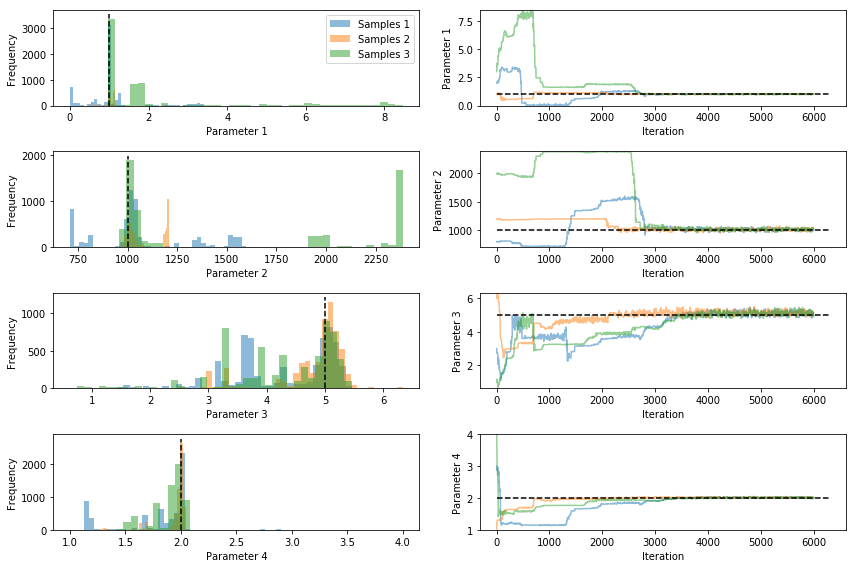

In [31]:
# Create a model
model = pints.toy.RepressilatorModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

# First add some noise
sigma = 5
noisy = values + np.random.normal(0, sigma, values.shape)

problem = pints.MultiOutputProblem(model, times, noisy)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, sigma)
log_prior = pints.UniformLogPrior([0, 500, 0, 0], [10, 3000, 20, 10])

# Initial guesses
x0 = [
    [2, 800, 3, 3],
    [1, 1200, 6, 1],
    [3, 2000, 1, 4],
]
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(6000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

In [28]:
samples=np.vstack(chains)
np.savetxt("repressilator.csv", samples, delimiter=",")

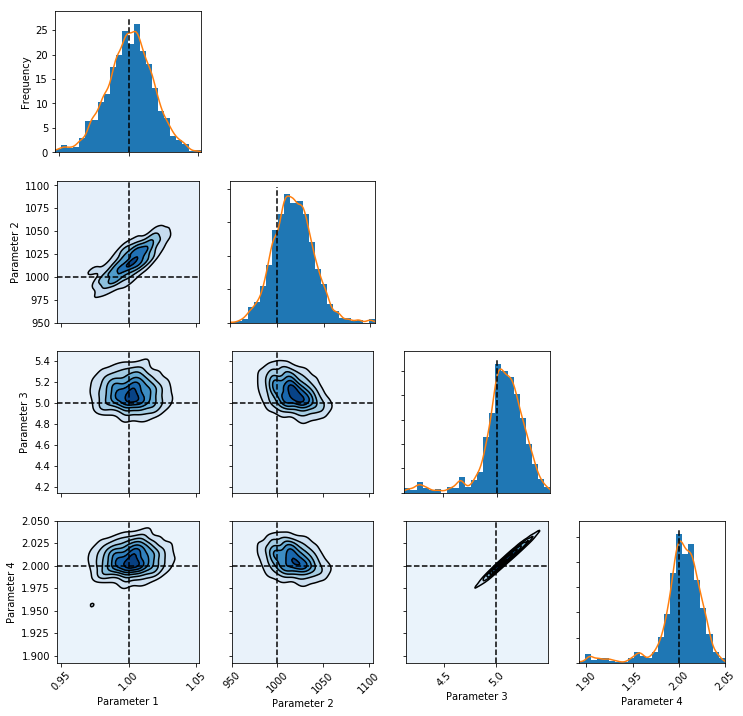

In [32]:
# Discard warm up
chains = chains[:, 3000:, :]

# Get samples
samples=np.vstack(chains)

# Look at distribution in chain 0
pints.plot.pairwise(samples, kde=True, ref_parameters=parameters)

# Show graphs
plt.show()

### Raised to temperature T=0.5

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.1
2     9      0.333     0.333     0.667      0:00.1
3     12     0.25      0.5       0.5        0:00.1
20    63     0.0952    0.19      0.19       0:00.6
40    123    0.122     0.146     0.171      0:01.1
60    183    0.115     0.115     0.246      0:01.6
80    243    0.111     0.123     0.222      0:02.0
100   303    0.139     0.109     0.188      0:02.5
120   363    0.132     0.0992    0.174      0:02.9
140   423    0.113     0.0922    0.163      0:03.3
160   483    0.112     0.0994    0.149      0:03.8
180   543    0.121547  0.116     0.138      0:04.2
Initial phase completed.
200   603    0.134     0.114     0.149      0:04.6
220   663    0.145     0.127     0.14       0:05.0
240   723    0.174     0.124     0.149      0:05.5
260   783    0.207     0.137

3100  9303   0.231     0.225     0.246      1:54.0
3120  9363   0.231     0.224     0.246075   1:54.9
3140  9423   0.232     0.226     0.2461     1:56.0
3160  9483   0.232205  0.226     0.246      1:57.0
3180  9543   0.232     0.226     0.248      1:58.1
3200  9603   0.233     0.227     0.248      1:59.3
3220  9663   0.233     0.227     0.248      2:00.2
3240  9723   0.233     0.227399  0.25       2:01.1
3260  9783   0.232444  0.227     0.249      2:01.9
3280  9843   0.234     0.227     0.249619   2:02.8
3300  9903   0.232     0.226598  0.251136   2:03.6
3320  9963   0.233     0.226     0.252      2:04.4
3340  10023  0.235     0.227     0.252619   2:05.3
3360  10083  0.237     0.226     0.253      2:06.1
3380  10143  0.238     0.225     0.253      2:07.0
3400  10203  0.238     0.225     0.254337   2:08.1
3420  10263  0.239     0.224     0.255      2:09.0
3440  10323  0.239     0.225     0.255449   2:09.8
3460  10383  0.239     0.225     0.256      2:10.6
3480  10443  0.238     0.225   

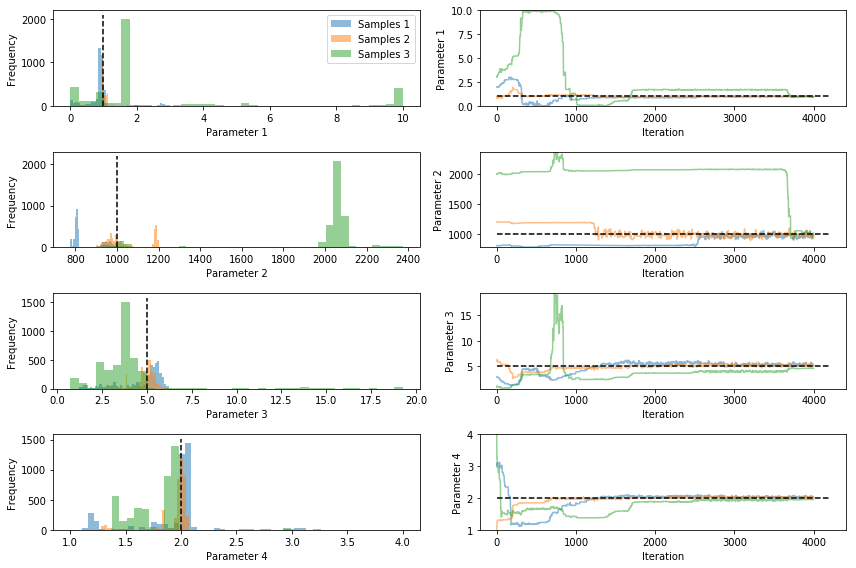

In [28]:
temperature = 0.7
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(4000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

In [37]:
samples=np.vstack(chains)
np.savetxt("repressilator-tempered-0.7.csv", samples, delimiter=",")

ESS = 1172


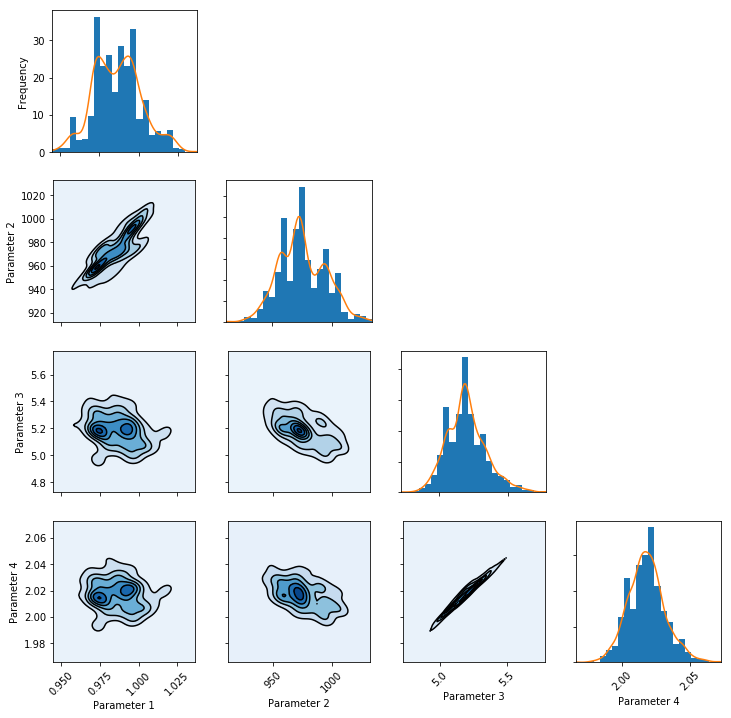

In [29]:
# Get samples
samples=np.vstack(chains)

log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))

print('ESS = ' + str(ess(w)))

idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

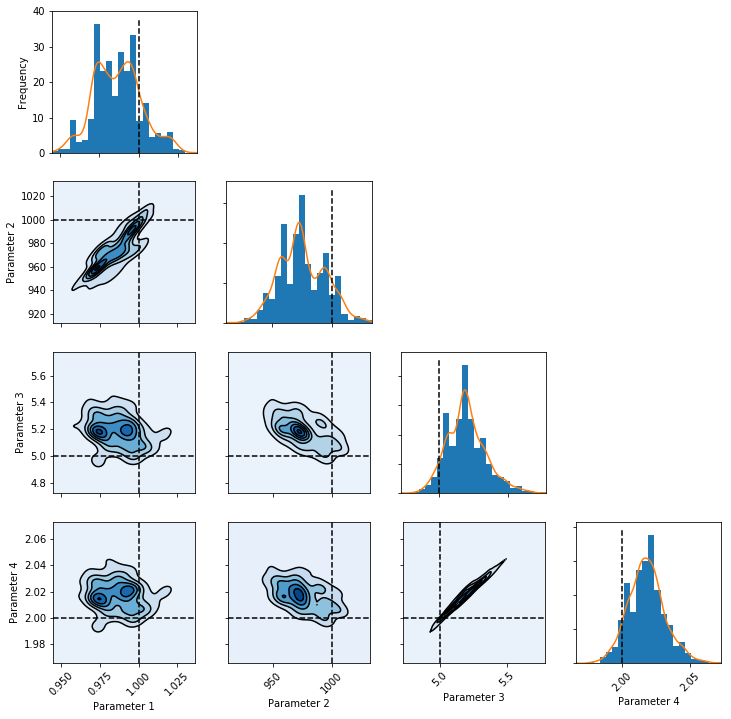

In [30]:
# Look at distribution in chain 0
pints.plot.pairwise(samples1, kde=True, ref_parameters=parameters)

# Show graphs
plt.show()

In [39]:
np.savetxt("repressilator-tempered-0.7-weights.csv", w, delimiter=",")

# Fitzhugh-Nagumo

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.667     0.333     0.667      0:00.1
3     12     0.75      0.5       0.5        0:00.1
20    63     0.238     0.333     0.524      0:00.4
40    123    0.146     0.244     0.341      0:00.7
60    183    0.0984    0.164     0.246      0:01.1
80    243    0.0864    0.123     0.185      0:01.4
100   303    0.0891    0.109     0.178      0:01.8
120   363    0.0744    0.0909    0.149      0:02.1
140   423    0.0709    0.0851    0.135      0:02.4
160   483    0.0621    0.0745    0.118      0:02.7
180   543    0.0608    0.0718    0.105      0:03.0
Initial phase completed.
200   603    0.0547    0.0697    0.0995     0:03.4
220   663    0.0633    0.0679    0.0995     0:03.8
240   723    0.083     0.104     0.116      0:04.2
260   783    0.111     0.142

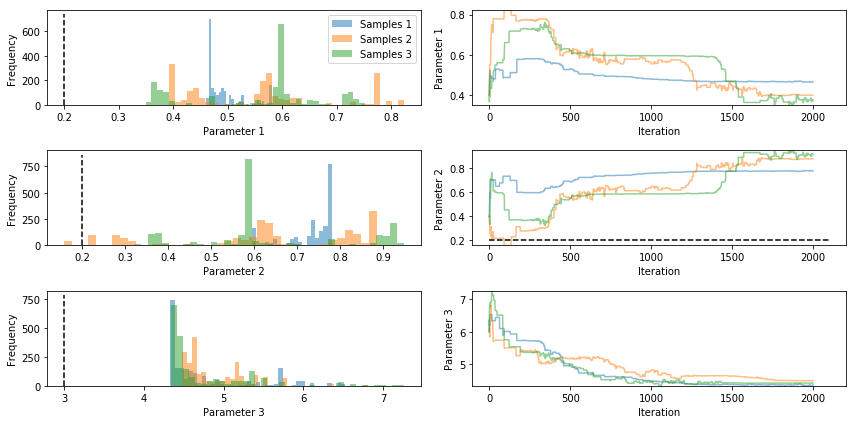

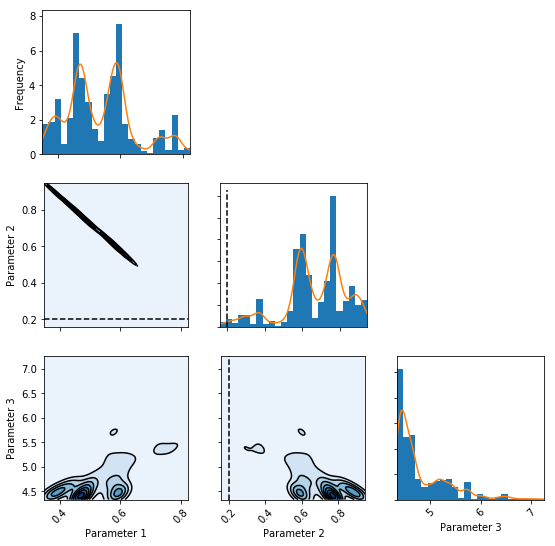

In [72]:
# Create a model
model = pints.toy.FitzhughNagumoModel(y0=[-1, 1])

# Run a simulation
parameters = [0.2, 0.2, 3]
times = np.linspace(0, 20, 401)
values = model.simulate(parameters, times)

# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

problem = pints.MultiOutputProblem(model, times, noisy)

log_likelihood = pints.KnownNoiseLogLikelihood(problem, sigma)

log_prior = pints.UniformLogPrior([0, 0, 0], [10, 10, 10])

# Initial guesses
x0 = [
    np.array([0.2, 0.2, 3])*2.0,
    np.array([0.2, 0.2, 3])*2.0,
    np.array([0.2, 0.2, 3])*2.0,
]

log_posterior = pints.LogPosterior(log_likelihood, log_prior)
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(2000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

# Get samples
samples=np.vstack(chains)

# Look at distribution in chain 0
pints.plot.pairwise(samples, kde=True, ref_parameters=parameters)

# Show graphs
plt.show()

In [56]:
samples=np.vstack(chains)
np.savetxt("../MCMC-within-IS/data/fitzhugh-nagumo.csv", samples, delimiter=",")

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.1
2     9      0         0.667     0          0:00.1
3     12     0.25      0.5       0.25       0:00.1
20    63     0.19      0.238     0.333      0:00.4
40    123    0.171     0.195122  0.268      0:00.7
60    183    0.115     0.18      0.23       0:01.1
80    243    0.0988    0.148     0.173      0:01.4
100   303    0.0792    0.119     0.149      0:01.7
120   363    0.0661    0.107438  0.124      0:02.0
140   423    0.0567    0.0922    0.106383   0:02.3
160   483    0.0559    0.0807    0.0932     0:02.6
180   543    0.0663    0.0773    0.0829     0:03.0
200   603    0.0597    0.0697    0.0796     0:03.3
220   663    0.0543    0.0633    0.0724     0:03.6
240   723    0.0498    0.0581    0.0664     0:03.9
260   783    0.0498    0.0536    0.0613     0:04.2
28

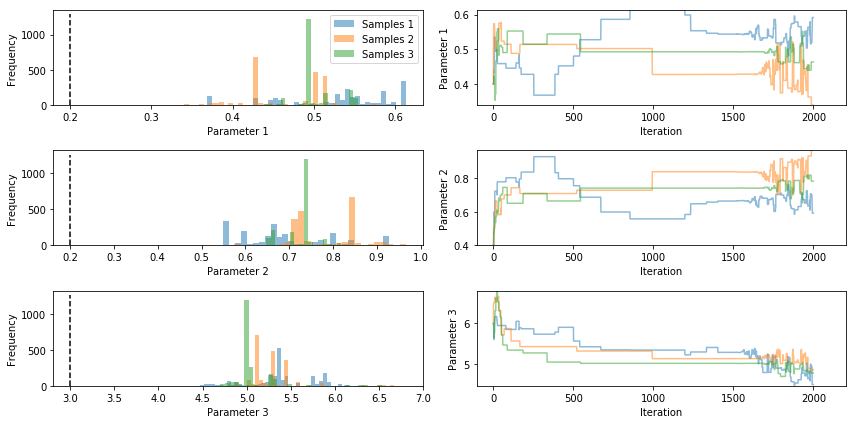

In [74]:
temperature = 0.95
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_initial_phase_iterations(200)
mcmc.set_max_iterations(2000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

In [50]:
samples=np.vstack(chains)
np.savetxt("../MCMC-within-IS/data/fitzhugh-nagumo-tempered-0.9.csv", samples, delimiter=",")

ESS = 39


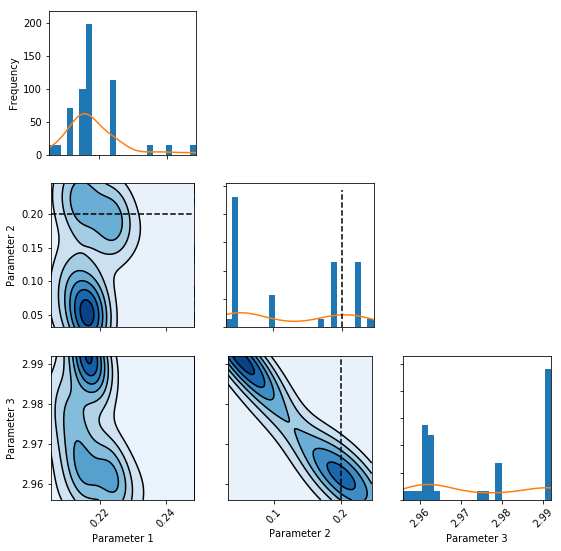

In [71]:
# Get samples
samples=np.vstack(chains)

log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))
np.savetxt("../MCMC-within-IS/data/fitzhugh-nagumo-0.9-weights.csv", w, delimiter=",")

print('ESS = ' + str(ess(w)))

idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

# Look at distribution in chain 0
pints.plot.pairwise(samples1, kde=True, ref_parameters=parameters)

# Show graphs
plt.show()

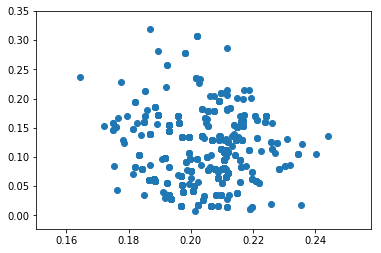

In [66]:
plt.scatter(samples1[:, 0], samples1[:, 1])
plt.show()

In [17]:
np.savetxt("fitzhugh-nagumo-tempered-0.9-weights.csv", w, delimiter=",")

## Try repelling

In [82]:
np.cov(np.transpose(samples))

array([[ 0.01155703, -0.01795427,  0.02796724],
       [-0.01795427,  0.02872161, -0.04977166],
       [ 0.02796724, -0.04977166,  0.27263567]])

In [ ]:
class TemperedLogPosterior1(pints.LogPDF):
    def __init__(self, temperature, a_mean, a_sd, log_posterior):
        self._temperature = temperature
        self._log_posterior = log_posterior
        self._mean = a_mean
        self._sd = a_sd
        
    def __call__(self, x):
        return (1.0 - self._temperature) * self._log_posterior(x) - (1.0 - self._temperature) * scipy.stats.multivariate_normal.logpdf(x, self._mean, self._sd)

    def n_parameters(self):
        return self._log_posterior.n_parameters()
def ess(w):
    return int(1.0 / np.sum(w**2))

temperature = 0.9
a_cov = [[0.2**2, 0, 0],
        [0, 0.2**2, 0],
        [0, 0, 0.5]]
log_posterior_t = TemperedLogPosterior1(temperature=temperature, a_mean=np.mean(samples, axis=0), a_sd=a_cov,
                                        log_posterior=log_posterior)
x0 = [np.mean(samples, axis=0)]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_initial_phase_iterations(200)
mcmc.set_max_iterations(2000)
chains = mcmc.run()

plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.1
3     12     0         0         0          0:00.1
20    63     0         0         0.0476     0:00.3
40    123    0.0244    0.0244    0.0244     0:00.6
60    183    0.0328    0.0164    0.0164     0:00.9
80    243    0.037     0.0247    0.0123     0:01.1
100   303    0.0297    0.0198    0.0099     0:01.4
120   363    0.0248    0.0165    0.00826    0:01.7
140   423    0.0284    0.0142    0.00709    0:02.1
160   483    0.0248    0.0124    0.00621    0:02.5
180   543    0.0221    0.011     0.00552    0:02.9
Initial phase completed.
200   603    0.0199    0.00995   0.00498    0:03.2
220   663    0.0271    0.00905   0.00452    0:03.7
240   723    0.0498    0.0166    0.0249     0:04.2
260   783    0.0805    0.026

# Multimodality in higher dimensions

## Untempered

In [104]:
n = 5
a=np.repeat(0, n)
b=np.repeat(10, n)
log_pdf = pints.toy.MultimodalNormalLogPDF([a.tolist(), b.tolist()])
nsamples = 100000

In [105]:
# Run MCMC on the noisy data
x0 = [np.repeat(0, n)]*3
mcmc = pints.MCMCSampling(log_pdf, 3, x0)
mcmc.set_max_iterations(nsamples)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:00.0
1     6       0.5       0.5       0.5        0:00.0
2     9       0.667     0.667     0.667      0:00.0
3     12      0.75      0.75      0.75       0:00.0
20    63      0.857     0.952381  0.952381   0:00.0
40    123     0.902439  0.976     0.976      0:00.1
60    183     0.934     0.967     0.984      0:00.1
80    243     0.951     0.962963  0.938      0:00.1
100   303     0.950495  0.960396  0.941      0:00.1
120   363     0.95      0.959     0.95       0:00.2
140   423     0.943     0.957     0.929078   0:00.2
160   483     0.95      0.957     0.931677   0:00.2
180   543     0.956     0.956     0.934      0:00.2
Initial phase completed.
200   603     0.95      0.960199  0.935      0:00.3
220   663     0.914     0.928     0.914      0:00.3
240   723     0.859     0.871     0.859      0:00.3
260

3160  9483    0.25087   0.254     0.249      0:04.5
3180  9543    0.25      0.254     0.249      0:04.6
3200  9603    0.25      0.254     0.249      0:04.6
3220  9663    0.25      0.254     0.248991   0:04.6
3240  9723    0.25      0.253     0.249      0:04.6
3260  9783    0.249     0.254     0.249      0:04.7
3280  9843    0.249     0.253886  0.249      0:04.7
3300  9903    0.249     0.254     0.25       0:04.7
3320  9963    0.25      0.254     0.249      0:04.8
3340  10023   0.25      0.253     0.25       0:04.8
3360  10083   0.25      0.253     0.251      0:04.8
3380  10143   0.25      0.252588  0.252      0:04.9
3400  10203   0.248     0.252     0.252      0:04.9
3420  10263   0.248     0.252     0.251      0:04.9
3440  10323   0.248     0.251     0.251671   0:04.9
3460  10383   0.248     0.251     0.252      0:05.0
3480  10443   0.247     0.25      0.251      0:05.0
3500  10503   0.247     0.249     0.251      0:05.0
3520  10563   0.248     0.249     0.250781   0:05.1
3540  10623 

6460  19383   0.241     0.244     0.235      0:09.3
6480  19443   0.241     0.244     0.235      0:09.3
6500  19503   0.241     0.244     0.235      0:09.3
6520  19563   0.24      0.244     0.2357     0:09.4
6540  19623   0.24      0.244     0.236      0:09.4
6560  19683   0.239     0.244     0.236      0:09.4
6580  19743   0.239     0.244     0.236      0:09.5
6600  19803   0.24      0.244     0.236      0:09.5
6620  19863   0.24      0.244     0.236      0:09.5
6640  19923   0.24      0.244     0.236      0:09.5
6660  19983   0.24      0.244     0.236      0:09.6
6680  20043   0.24      0.244     0.236      0:09.6
6700  20103   0.24      0.243     0.237      0:09.6
6720  20163   0.24      0.244     0.237      0:09.7
6740  20223   0.239727  0.243584  0.237      0:09.7
6760  20283   0.24      0.244     0.237      0:09.7
6780  20343   0.239     0.243     0.237      0:09.7
6800  20403   0.239     0.243     0.237      0:09.8
6820  20463   0.239     0.242633  0.237      0:09.8
6840  20523 

9660  28983   0.239     0.239     0.235      0:13.8
9680  29043   0.24      0.239     0.235      0:13.9
9700  29103   0.239     0.239     0.236      0:13.9
9720  29163   0.239     0.239     0.236      0:13.9
9740  29223   0.239     0.239     0.236      0:13.9
9760  29283   0.239     0.239     0.235      0:14.0
9780  29343   0.239     0.239     0.236      0:14.0
9800  29403   0.239     0.239     0.235      0:14.0
9820  29463   0.239     0.24      0.235      0:14.1
9840  29523   0.239     0.239813  0.236      0:14.1
9860  29583   0.239     0.239428  0.236      0:14.1
9880  29643   0.239     0.239     0.236      0:14.1
9900  29703   0.239     0.239     0.236      0:14.2
9920  29763   0.238484  0.239     0.236      0:14.2
9940  29823   0.239     0.239     0.236      0:14.2
9960  29883   0.238     0.239     0.236      0:14.3
9980  29943   0.238     0.238     0.236      0:14.3
10000 30003   0.238     0.238     0.236      0:14.3
10020 30063   0.237601  0.2381    0.236      0:14.3
10040 30123 

12860 38583   0.237     0.238     0.235      0:18.4
12880 38643   0.237     0.237     0.235      0:18.4
12900 38703   0.237     0.237     0.235      0:18.4
12920 38763   0.237     0.237     0.235      0:18.5
12940 38823   0.237     0.237     0.234835   0:18.5
12960 38883   0.237     0.237     0.235      0:18.5
12980 38943   0.237     0.237     0.235      0:18.5
13000 39003   0.237     0.236751  0.235      0:18.6
13020 39063   0.236925  0.237     0.234621   0:18.6
13040 39123   0.236715  0.237     0.234      0:18.6
13060 39183   0.237     0.237     0.234      0:18.7
13080 39243   0.236     0.237     0.234      0:18.7
13100 39303   0.236     0.237     0.234      0:18.7
13120 39363   0.236     0.237     0.234      0:18.7
13140 39423   0.236     0.237     0.234      0:18.8
13160 39483   0.236     0.237     0.234      0:18.8
13180 39543   0.236     0.236     0.233      0:18.8
13200 39603   0.235967  0.236     0.234      0:18.8
13220 39663   0.236     0.236     0.233      0:18.9
13240 39723 

16020 48063   0.235     0.236     0.234255   0:22.9
16040 48123   0.235     0.236     0.234      0:22.9
16060 48183   0.235     0.236     0.234      0:22.9
16080 48243   0.23506   0.236055  0.234      0:23.0
16100 48303   0.235     0.236     0.234      0:23.0
16120 48363   0.235     0.236     0.234      0:23.0
16140 48423   0.235     0.235797  0.234      0:23.1
16160 48483   0.235     0.235629  0.234      0:23.1
16180 48543   0.235     0.236     0.234      0:23.1
16200 48603   0.235     0.236     0.234      0:23.1
16220 48663   0.235     0.236     0.234      0:23.2
16240 48723   0.235     0.236     0.235      0:23.2
16260 48783   0.235     0.236     0.235      0:23.2
16280 48843   0.235     0.236     0.235      0:23.3
16300 48903   0.235     0.236     0.235      0:23.3
16320 48963   0.235     0.236     0.235      0:23.3
16340 49023   0.234747  0.236     0.235      0:23.4
16360 49083   0.235     0.235     0.235      0:23.4
16380 49143   0.235     0.235     0.235      0:23.4
16400 49203 

19280 57843   0.235     0.234     0.234      0:27.6
19300 57903   0.235     0.234     0.234      0:27.7
19320 57963   0.235     0.234     0.234      0:27.7
19340 58023   0.235     0.233     0.234      0:27.7
19360 58083   0.235     0.233459  0.234      0:27.7
19380 58143   0.235     0.233     0.234      0:27.8
19400 58203   0.235     0.233     0.234      0:27.8
19420 58263   0.235     0.233     0.234025   0:27.8
19440 58323   0.235     0.233     0.234      0:27.9
19460 58383   0.235     0.233544  0.234      0:27.9
19480 58443   0.235     0.234     0.234      0:27.9
19500 58503   0.235     0.234     0.234      0:28.0
19520 58563   0.235     0.234     0.234      0:28.0
19540 58623   0.235     0.233     0.234      0:28.0
19560 58683   0.235     0.233     0.234      0:28.0
19580 58743   0.235     0.233     0.234      0:28.1
19600 58803   0.234988  0.233     0.234      0:28.1
19620 58863   0.235     0.233     0.234      0:28.1
19640 58923   0.235     0.233     0.234      0:28.2
19660 58983 

22460 67383   0.234     0.235     0.234718   0:32.2
22480 67443   0.235     0.235     0.235      0:32.2
22500 67503   0.235     0.235     0.235      0:32.3
22520 67563   0.234     0.235     0.235      0:32.3
22540 67623   0.235     0.235     0.235      0:32.3
22560 67683   0.235     0.235     0.235      0:32.4
22580 67743   0.235     0.235     0.234622   0:32.4
22600 67803   0.235     0.235     0.235      0:32.4
22620 67863   0.235     0.235     0.234      0:32.5
22640 67923   0.235     0.235     0.234      0:32.5
22660 67983   0.235     0.235     0.234235   0:32.5
22680 68043   0.234     0.235     0.234      0:32.5
22700 68103   0.234439  0.235     0.234      0:32.6
22720 68163   0.235     0.235     0.234      0:32.6
22740 68223   0.235     0.235     0.234      0:32.6
22760 68283   0.235     0.235     0.234      0:32.7
22780 68343   0.235     0.235     0.234      0:32.7
22800 68403   0.235     0.235     0.234      0:32.7
22820 68463   0.235     0.234959  0.234      0:32.7
22840 68523 

25620 76863   0.234     0.234     0.233      0:36.8
25640 76923   0.234     0.234     0.234      0:36.8
25660 76983   0.234     0.234     0.233662   0:36.8
25680 77043   0.234     0.234142  0.234      0:36.9
25700 77103   0.234     0.234     0.233843   0:36.9
25720 77163   0.234     0.234     0.234      0:36.9
25740 77223   0.234     0.234     0.234      0:36.9
25760 77283   0.234     0.234     0.234      0:37.0
25780 77343   0.233932  0.234     0.234      0:37.0
25800 77403   0.234     0.234     0.234      0:37.0
25820 77463   0.234     0.234     0.234      0:37.1
25840 77523   0.234     0.234     0.234      0:37.1
25860 77583   0.233943  0.234     0.233943   0:37.1
25880 77643   0.234     0.234     0.234      0:37.1
25900 77703   0.234     0.234     0.233852   0:37.2
25920 77763   0.234     0.234     0.234      0:37.2
25940 77823   0.234     0.234     0.234      0:37.2
25960 77883   0.234     0.234     0.234      0:37.3
25980 77943   0.234     0.234     0.234      0:37.3
26000 78003 

28820 86463   0.234     0.234     0.234      0:41.3
28840 86523   0.234     0.234     0.234      0:41.3
28860 86583   0.234     0.234     0.234      0:41.4
28880 86643   0.233683  0.234     0.234      0:41.4
28900 86703   0.234     0.234     0.234      0:41.4
28920 86763   0.234     0.234     0.233671   0:41.5
28940 86823   0.234     0.234     0.234      0:41.5
28960 86883   0.234     0.234     0.234      0:41.5
28980 86943   0.234     0.234     0.234      0:41.5
29000 87003   0.233785  0.234     0.234      0:41.6
29020 87063   0.234     0.234     0.234      0:41.6
29040 87123   0.234     0.234     0.234      0:41.6
29060 87183   0.234     0.234     0.233      0:41.7
29080 87243   0.234     0.234     0.233417   0:41.7
29100 87303   0.234     0.234     0.233      0:41.7
29120 87363   0.233     0.234     0.233      0:41.7
29140 87423   0.233     0.234     0.233      0:41.8
29160 87483   0.233     0.234     0.233      0:41.8
29180 87543   0.233     0.234     0.233      0:41.8
29200 87603 

32100 96303   0.234     0.234     0.234      0:46.1
32120 96363   0.234     0.234     0.234      0:46.1
32140 96423   0.234     0.234     0.234      0:46.1
32160 96483   0.233     0.234     0.234      0:46.2
32180 96543   0.233     0.234424  0.234      0:46.2
32200 96603   0.23344   0.234     0.234      0:46.2
32220 96663   0.234     0.234     0.234      0:46.2
32240 96723   0.234     0.234422  0.234      0:46.3
32260 96783   0.234     0.234     0.234      0:46.3
32280 96843   0.23345   0.234     0.234      0:46.3
32300 96903   0.233     0.235     0.234      0:46.4
32320 96963   0.233     0.235     0.233      0:46.4
32340 97023   0.233     0.235     0.234      0:46.4
32360 97083   0.233     0.235     0.234      0:46.4
32380 97143   0.233285  0.235     0.23381    0:46.5
32400 97203   0.234     0.235     0.234      0:46.5
32420 97263   0.234     0.235     0.234      0:46.5
32440 97323   0.234     0.235     0.234      0:46.6
32460 97383   0.234     0.23462   0.234      0:46.6
32480 97443 

35280 105843  0.233     0.234     0.235      0:50.6
35300 105903  0.233     0.234     0.235      0:50.7
35320 105963  0.233     0.235     0.235      0:50.7
35340 106023  0.233     0.235     0.235      0:50.7
35360 106083  0.234     0.235     0.235      0:50.8
35380 106143  0.233     0.235     0.234674   0:50.8
35400 106203  0.234     0.235     0.235      0:50.8
35420 106263  0.234     0.235     0.235      0:50.8
35440 106323  0.234     0.234     0.235      0:50.9
35460 106383  0.234     0.235     0.235      0:50.9
35480 106443  0.234     0.235     0.235      0:50.9
35500 106503  0.234     0.235     0.235      0:51.0
35520 106563  0.234     0.235     0.235      0:51.0
35540 106623  0.234     0.235     0.235      0:51.0
35560 106683  0.234     0.235     0.235      0:51.1
35580 106743  0.234     0.234     0.234732   0:51.1
35600 106803  0.234     0.234     0.235      0:51.1
35620 106863  0.233935  0.234     0.235      0:51.1
35640 106923  0.234     0.235     0.235      0:51.2
35660 106983

38560 115683  0.233     0.235     0.234      0:55.4
38580 115743  0.233     0.235     0.235      0:55.4
38600 115803  0.233     0.235     0.235      0:55.5
38620 115863  0.233241  0.234924  0.235      0:55.5
38640 115923  0.233     0.235     0.235      0:55.5
38660 115983  0.233     0.235     0.235      0:55.6
38680 116043  0.233     0.235     0.235      0:55.6
38700 116103  0.233     0.235     0.234      0:55.6
38720 116163  0.233     0.235     0.234      0:55.7
38740 116223  0.233     0.235203  0.234      0:55.7
38760 116283  0.233     0.235     0.234      0:55.7
38780 116343  0.233     0.235     0.234      0:55.7
38800 116403  0.233     0.235     0.234      0:55.8
38820 116463  0.233     0.235     0.234      0:55.8
38840 116523  0.233     0.235     0.23434    0:55.8
38860 116583  0.233     0.235     0.234      0:55.9
38880 116643  0.233     0.235     0.234      0:55.9
38900 116703  0.233     0.235     0.234287   0:55.9
38920 116763  0.233     0.235     0.234      0:55.9
38940 116823

41740 125223  0.233751  0.235     0.234      1:00.0
41760 125283  0.234     0.235     0.234      1:00.0
41780 125343  0.234     0.235059  0.234      1:00.1
41800 125403  0.233559  0.235114  0.234      1:00.1
41820 125463  0.234     0.235     0.234      1:00.1
41840 125523  0.233503  0.235     0.234      1:00.1
41860 125583  0.234     0.235     0.234      1:00.2
41880 125643  0.233662  0.235     0.234      1:00.2
41900 125703  0.234     0.235     0.234      1:00.2
41920 125763  0.234     0.235     0.234      1:00.3
41940 125823  0.234     0.235     0.234      1:00.3
41960 125883  0.234     0.235     0.234      1:00.3
41980 125943  0.234     0.235     0.233963   1:00.4
42000 126003  0.234     0.235     0.234      1:00.4
42020 126063  0.234     0.235     0.234      1:00.4
42040 126123  0.234     0.235     0.234      1:00.4
42060 126183  0.234     0.235     0.234      1:00.5
42080 126243  0.234     0.235     0.233906   1:00.5
42100 126303  0.234     0.235     0.234      1:00.5
42120 126363

45020 135063  0.234     0.234     0.234      1:04.8
45040 135123  0.234     0.234     0.233      1:04.8
45060 135183  0.234     0.234     0.233      1:04.8
45080 135243  0.234     0.234     0.233      1:04.8
45100 135303  0.234     0.234     0.233      1:04.9
45120 135363  0.233572  0.234     0.233      1:04.9
45140 135423  0.234     0.234     0.233      1:04.9
45160 135483  0.234     0.234     0.233      1:05.0
45180 135543  0.234     0.234     0.233      1:05.0
45200 135603  0.234     0.234     0.233      1:05.0
45220 135663  0.234     0.234     0.233365   1:05.1
45240 135723  0.234     0.234     0.233      1:05.1
45260 135783  0.234     0.234     0.233      1:05.1
45280 135843  0.234     0.234     0.234      1:05.1
45300 135903  0.234     0.234     0.233      1:05.2
45320 135963  0.234     0.234     0.233      1:05.2
45340 136023  0.234     0.234     0.233      1:05.2
45360 136083  0.234     0.234     0.233      1:05.3
45380 136143  0.234     0.234     0.233      1:05.3
45400 136203

48200 144603  0.234     0.235     0.234      1:09.4
48220 144663  0.234     0.235     0.233923   1:09.4
48240 144723  0.234     0.235     0.234      1:09.4
48260 144783  0.234     0.234     0.234      1:09.4
48280 144843  0.234     0.234     0.234      1:09.5
48300 144903  0.234     0.234     0.234      1:09.5
48320 144963  0.234     0.234     0.234      1:09.5
48340 145023  0.234     0.234     0.234      1:09.6
48360 145083  0.234     0.234     0.234      1:09.6
48380 145143  0.234     0.234     0.234      1:09.6
48400 145203  0.234     0.234     0.234      1:09.6
48420 145263  0.234     0.234     0.234      1:09.7
48440 145323  0.234     0.234     0.234      1:09.7
48460 145383  0.234     0.234     0.234      1:09.7
48480 145443  0.234     0.234     0.234      1:09.8
48500 145503  0.234     0.234     0.234      1:09.8
48520 145563  0.234     0.234     0.234      1:09.8
48540 145623  0.234     0.234     0.234      1:09.8
48560 145683  0.234     0.234     0.234      1:09.9
48580 145743

51400 154203  0.234     0.234     0.233653   1:13.9
51420 154263  0.233815  0.23399   0.234      1:14.0
51440 154323  0.233763  0.234     0.234      1:14.0
51460 154383  0.234     0.233983  0.234      1:14.0
51480 154443  0.234     0.234     0.234      1:14.1
51500 154503  0.234     0.234     0.234      1:14.1
51520 154563  0.234     0.234     0.234      1:14.1
51540 154623  0.234     0.234     0.234      1:14.1
51560 154683  0.234     0.234     0.233568   1:14.2
51580 154743  0.234     0.234     0.233555   1:14.2
51600 154803  0.234     0.234     0.233      1:14.2
51620 154863  0.234     0.234     0.234      1:14.3
51640 154923  0.234     0.234     0.234      1:14.3
51660 154983  0.234     0.234     0.234      1:14.3
51680 155043  0.234     0.234     0.234      1:14.4
51700 155103  0.234     0.234     0.234      1:14.4
51720 155163  0.234     0.234     0.234      1:14.4
51740 155223  0.234     0.234     0.234      1:14.4
51760 155283  0.234     0.234     0.234      1:14.5
51780 155343

54580 163743  0.234     0.234     0.233      1:18.5
54600 163803  0.234     0.234     0.233      1:18.6
54620 163863  0.234     0.234     0.233      1:18.6
54640 163923  0.234     0.234     0.233      1:18.6
54660 163983  0.234     0.234     0.233      1:18.7
54680 164043  0.234     0.234     0.233      1:18.7
54700 164103  0.234     0.234     0.233      1:18.7
54720 164163  0.233658  0.234     0.233      1:18.7
54740 164223  0.234     0.234     0.233      1:18.8
54760 164283  0.234     0.234     0.233      1:18.8
54780 164343  0.234     0.234     0.233      1:18.8
54800 164403  0.234     0.234     0.233      1:18.9
54820 164463  0.234     0.234     0.233      1:18.9
54840 164523  0.234     0.234     0.233      1:18.9
54860 164583  0.234     0.234     0.233      1:18.9
54880 164643  0.234     0.234     0.233      1:19.0
54900 164703  0.234     0.233912  0.233      1:19.0
54920 164763  0.234     0.234     0.233      1:19.0
54940 164823  0.234     0.234     0.233232   1:19.1
54960 164883

57740 173223  0.234     0.234     0.234      1:23.1
57760 173283  0.234293  0.234     0.234      1:23.1
57780 173343  0.234     0.233987  0.234      1:23.2
57800 173403  0.234     0.234     0.233733   1:23.2
57820 173463  0.234     0.234     0.234      1:23.2
57840 173523  0.234     0.233969  0.234      1:23.2
57860 173583  0.234     0.234     0.234      1:23.3
57880 173643  0.234     0.234     0.234      1:23.3
57900 173703  0.234     0.234     0.233692   1:23.3
57920 173763  0.234     0.234     0.234      1:23.4
57940 173823  0.234     0.234     0.234      1:23.4
57960 173883  0.234     0.234     0.234      1:23.4
57980 173943  0.234     0.234     0.234      1:23.4
58000 174003  0.234     0.234     0.234      1:23.5
58020 174063  0.234     0.234     0.234      1:23.5
58040 174123  0.234     0.234     0.234      1:23.5
58060 174183  0.234     0.234047  0.233668   1:23.6
58080 174243  0.234     0.234     0.234      1:23.6
58100 174303  0.234     0.234     0.234      1:23.6
58120 174363

60900 182703  0.234     0.234     0.234      1:27.7
60920 182763  0.234     0.233     0.234205   1:27.7
60940 182823  0.234     0.233     0.234243   1:27.7
60960 182883  0.234     0.233     0.234      1:27.7
60980 182943  0.234     0.234     0.234      1:27.8
61000 183003  0.233865  0.234     0.234      1:27.8
61020 183063  0.234     0.233     0.234      1:27.8
61040 183123  0.234     0.233     0.234      1:27.9
61060 183183  0.234     0.233     0.234      1:27.9
61080 183243  0.234     0.233     0.234      1:27.9
61100 183303  0.234     0.233     0.234317   1:27.9
61120 183363  0.234     0.233504  0.234      1:28.0
61140 183423  0.234     0.233     0.234      1:28.0
61160 183483  0.234     0.233     0.234      1:28.0
61180 183543  0.234     0.233     0.234      1:28.1
61200 183603  0.234     0.233     0.234      1:28.1
61220 183663  0.234     0.233433  0.234266   1:28.1
61240 183723  0.234     0.233471  0.234      1:28.1
61260 183783  0.234     0.233     0.234      1:28.2
61280 183843

64100 192303  0.234     0.234     0.234      1:32.2
64120 192363  0.234     0.234     0.234      1:32.2
64140 192423  0.234     0.234     0.234078   1:32.3
64160 192483  0.234     0.234     0.234      1:32.3
64180 192543  0.234     0.234     0.234      1:32.3
64200 192603  0.234     0.234     0.234      1:32.3
64220 192663  0.234     0.234     0.234129   1:32.4
64240 192723  0.234     0.234     0.234      1:32.4
64260 192783  0.234279  0.234     0.234      1:32.4
64280 192843  0.234     0.234     0.234      1:32.5
64300 192903  0.234     0.234     0.234      1:32.5
64320 192963  0.234247  0.234     0.234      1:32.5
64340 193023  0.234     0.234     0.234112   1:32.5
64360 193083  0.234     0.234     0.234148   1:32.6
64380 193143  0.234     0.234     0.234      1:32.6
64400 193203  0.234     0.234     0.234      1:32.6
64420 193263  0.234     0.234     0.234      1:32.7
64440 193323  0.234     0.234     0.234      1:32.7
64460 193383  0.234     0.234     0.234      1:32.7
64480 193443

67380 202143  0.234     0.234     0.234      1:37.0
67400 202203  0.234     0.234     0.234      1:37.0
67420 202263  0.234     0.234     0.234      1:37.0
67440 202323  0.234     0.234     0.234      1:37.1
67460 202383  0.234     0.234     0.234      1:37.1
67480 202443  0.234     0.233725  0.234      1:37.1
67500 202503  0.233641  0.234     0.234      1:37.1
67520 202563  0.234     0.234     0.234      1:37.2
67540 202623  0.234     0.234     0.234      1:37.2
67560 202683  0.234     0.234     0.234      1:37.2
67580 202743  0.234     0.234     0.234      1:37.3
67600 202803  0.23368   0.234     0.234      1:37.3
67620 202863  0.234     0.234     0.234      1:37.3
67640 202923  0.234     0.234     0.234      1:37.4
67660 202983  0.234     0.234     0.234      1:37.4
67680 203043  0.234     0.234     0.234      1:37.4
67700 203103  0.234     0.234     0.234      1:37.5
67720 203163  0.234     0.233768  0.234      1:37.5
67740 203223  0.234     0.234     0.234      1:37.5
67760 203283

70540 211623  0.234     0.234     0.234      1:41.5
70560 211683  0.234     0.234     0.234      1:41.6
70580 211743  0.234     0.234     0.234      1:41.6
70600 211803  0.234     0.234     0.234      1:41.6
70620 211863  0.234     0.234     0.234      1:41.7
70640 211923  0.234     0.234     0.234      1:41.7
70660 211983  0.234     0.233948  0.234      1:41.7
70680 212043  0.234     0.234     0.234      1:41.7
70700 212103  0.234     0.234     0.234      1:41.8
70720 212163  0.234     0.234     0.234      1:41.8
70740 212223  0.233641  0.234     0.234      1:41.8
70760 212283  0.234     0.2339    0.234      1:41.9
70780 212343  0.234     0.234     0.23406    1:41.9
70800 212403  0.234     0.234     0.234      1:41.9
70820 212463  0.234     0.234     0.234      1:41.9
70840 212523  0.233523  0.234     0.234      1:42.0
70860 212583  0.234     0.234     0.234      1:42.0
70880 212643  0.234     0.234     0.234      1:42.0
70900 212703  0.234     0.234     0.23396    1:42.1
70920 212763

73720 221163  0.233     0.234     0.234      1:46.1
73740 221223  0.233     0.234     0.234      1:46.1
73760 221283  0.233     0.234     0.234      1:46.2
73780 221343  0.233     0.234     0.234      1:46.2
73800 221403  0.233     0.234     0.234      1:46.2
73820 221463  0.233     0.234     0.234      1:46.3
73840 221523  0.233     0.234     0.234      1:46.3
73860 221583  0.233     0.234     0.234      1:46.3
73880 221643  0.233     0.234     0.234      1:46.3
73900 221703  0.233     0.234     0.234      1:46.4
73920 221763  0.233     0.234     0.234      1:46.4
73940 221823  0.233     0.234     0.234      1:46.4
73960 221883  0.233     0.234     0.234      1:46.5
73980 221943  0.233     0.234     0.234      1:46.5
74000 222003  0.233     0.233605  0.233632   1:46.5
74020 222063  0.233     0.234     0.234      1:46.5
74040 222123  0.233     0.234     0.234      1:46.6
74060 222183  0.233     0.234     0.234      1:46.6
74080 222243  0.233     0.234     0.234      1:46.6
74100 222303

76920 230763  0.234     0.234     0.233      1:50.7
76940 230823  0.234     0.234     0.233      1:50.7
76960 230883  0.234     0.234     0.234      1:50.8
76980 230943  0.234     0.234     0.234      1:50.8
77000 231003  0.234     0.233971  0.233      1:50.8
77020 231063  0.234     0.234     0.234      1:50.8
77040 231123  0.233538  0.234     0.233538   1:50.9
77060 231183  0.234     0.234     0.234      1:50.9
77080 231243  0.234     0.234     0.234      1:50.9
77100 231303  0.234     0.234     0.234      1:51.0
77120 231363  0.233     0.234     0.233594   1:51.0
77140 231423  0.234     0.234     0.234      1:51.0
77160 231483  0.234     0.233758  0.234      1:51.1
77180 231543  0.234     0.234     0.234      1:51.1
77200 231603  0.233598  0.234     0.234      1:51.1
77220 231663  0.234     0.234     0.234      1:51.1
77240 231723  0.234     0.234     0.234      1:51.2
77260 231783  0.234     0.234     0.234      1:51.2
77280 231843  0.234     0.234     0.234      1:51.2
77300 231903

80080 240243  0.234     0.234     0.233      1:55.3
80100 240303  0.234     0.234     0.233      1:55.3
80120 240363  0.234     0.234     0.233      1:55.4
80140 240423  0.234     0.234     0.233      1:55.4
80160 240483  0.234     0.234     0.233056   1:55.4
80180 240543  0.234     0.234     0.233      1:55.4
80200 240603  0.234     0.234     0.233027   1:55.5
80220 240663  0.234     0.234     0.233      1:55.5
80240 240723  0.234     0.234     0.233      1:55.5
80260 240783  0.234     0.234     0.233      1:55.6
80280 240843  0.234     0.234     0.233      1:55.6
80300 240903  0.233621  0.234     0.233      1:55.6
80320 240963  0.234     0.234     0.233      1:55.6
80340 241023  0.234     0.234     0.233      1:55.7
80360 241083  0.233571  0.234     0.233      1:55.7
80380 241143  0.234     0.234     0.233      1:55.7
80400 241203  0.234     0.234     0.233      1:55.8
80420 241263  0.234     0.234     0.233      1:55.8
80440 241323  0.233     0.234     0.233      1:55.8
80460 241383

83260 249783  0.233     0.234     0.233      1:59.8
83280 249843  0.233     0.234     0.233      1:59.9
83300 249903  0.234     0.234     0.233      1:59.9
83320 249963  0.234     0.234     0.233      1:59.9
83340 250023  0.234     0.234     0.233      1:59.9
83360 250083  0.234     0.234     0.233      2:00.0
83380 250143  0.234     0.234286  0.233      2:00.0
83400 250203  0.234     0.234     0.233      2:00.0
83420 250263  0.234     0.234     0.233      2:00.1
83440 250323  0.234     0.234     0.233      2:00.1
83460 250383  0.234     0.234     0.233      2:00.1
83480 250443  0.234     0.234     0.233      2:00.1
83500 250503  0.233578  0.234     0.233      2:00.2
83520 250563  0.234     0.234     0.233      2:00.2
83540 250623  0.234     0.234     0.233      2:00.2
83560 250683  0.234     0.234248  0.233      2:00.3
83580 250743  0.234     0.234     0.233      2:00.3
83600 250803  0.234     0.234     0.233      2:00.3
83620 250863  0.234     0.234     0.233      2:00.3
83640 250923

86440 259323  0.233     0.234     0.234      2:04.4
86460 259383  0.233     0.234     0.234      2:04.4
86480 259443  0.234     0.234     0.234      2:04.4
86500 259503  0.234     0.234     0.234      2:04.5
86520 259563  0.234     0.234     0.234      2:04.5
86540 259623  0.233554  0.234     0.234      2:04.5
86560 259683  0.234     0.234     0.234      2:04.6
86580 259743  0.234     0.23422   0.234      2:04.6
86600 259803  0.234     0.234189  0.234      2:04.6
86620 259863  0.233     0.234     0.234      2:04.6
86640 259923  0.233     0.234     0.23385    2:04.7
86660 259983  0.234     0.234223  0.234      2:04.7
86680 260043  0.234     0.234192  0.234      2:04.7
86700 260103  0.234     0.234     0.234      2:04.8
86720 260163  0.234     0.234     0.234      2:04.8
86740 260223  0.234     0.234     0.234      2:04.8
86760 260283  0.234     0.234     0.234      2:04.8
86780 260343  0.234     0.234     0.233853   2:04.9
86800 260403  0.234     0.234     0.234      2:04.9
86820 260463

89600 268803  0.233     0.234     0.23358    2:09.0
89620 268863  0.234     0.23403   0.234      2:09.0
89640 268923  0.234     0.234     0.234      2:09.0
89660 268983  0.234     0.234     0.234      2:09.0
89680 269043  0.233472  0.234     0.234      2:09.1
89700 269103  0.233     0.234     0.234      2:09.1
89720 269163  0.233     0.234     0.234      2:09.1
89740 269223  0.233     0.234     0.233561   2:09.2
89760 269283  0.233     0.234     0.234      2:09.2
89780 269343  0.233457  0.234025  0.234      2:09.2
89800 269403  0.233405  0.234     0.234      2:09.3
89820 269463  0.233     0.234     0.234      2:09.3
89840 269523  0.233     0.234     0.234      2:09.3
89860 269583  0.233     0.234     0.234      2:09.3
89880 269643  0.233     0.234     0.233531   2:09.4
89900 269703  0.233     0.234     0.233479   2:09.4
89920 269763  0.233     0.234     0.233      2:09.4
89940 269823  0.233     0.234     0.233542   2:09.5
89960 269883  0.233     0.234     0.234      2:09.5
89980 269943

92800 278403  0.234     0.233963  0.234      2:13.5
92820 278463  0.234     0.234     0.234      2:13.6
92840 278523  0.234     0.234     0.234      2:13.6
92860 278583  0.234     0.234     0.234      2:13.6
92880 278643  0.234     0.234     0.234      2:13.6
92900 278703  0.234     0.234     0.234      2:13.7
92920 278763  0.234     0.234     0.234      2:13.7
92940 278823  0.234     0.234     0.234      2:13.7
92960 278883  0.234     0.234     0.234      2:13.7
92980 278943  0.234     0.234     0.234      2:13.8
93000 279003  0.234     0.234     0.234      2:13.8
93020 279063  0.234     0.234     0.234      2:13.8
93040 279123  0.234     0.234     0.234      2:13.9
93060 279183  0.234     0.234     0.234      2:13.9
93080 279243  0.23356   0.234     0.234      2:13.9
93100 279303  0.234     0.234     0.234      2:13.9
93120 279363  0.234     0.234     0.234      2:14.0
93140 279423  0.234     0.234     0.234      2:14.0
93160 279483  0.234     0.234     0.234      2:14.0
93180 279543

96000 288003  0.233     0.234008  0.234      2:18.1
96020 288063  0.233     0.234     0.233626   2:18.1
96040 288123  0.233     0.234     0.234      2:18.1
96060 288183  0.233     0.234018  0.234      2:18.2
96080 288243  0.233     0.234     0.234      2:18.2
96100 288303  0.233     0.234     0.234      2:18.2
96120 288363  0.233     0.234     0.233643   2:18.2
96140 288423  0.233     0.234     0.234      2:18.3
96160 288483  0.233     0.234     0.233629   2:18.3
96180 288543  0.233     0.234     0.234      2:18.3
96200 288603  0.233     0.234     0.234      2:18.4
96220 288663  0.233369  0.234     0.234      2:18.4
96240 288723  0.233     0.234     0.234      2:18.4
96260 288783  0.233     0.234     0.234      2:18.4
96280 288843  0.233     0.234     0.234      2:18.5
96300 288903  0.233     0.234     0.234      2:18.5
96320 288963  0.233     0.23403   0.234      2:18.5
96340 289023  0.233     0.234     0.234      2:18.6
96360 289083  0.233     0.234     0.234      2:18.6
96380 289143

99200 297603  0.233     0.23404   0.234      2:22.6
99220 297663  0.234     0.234     0.234      2:22.6
99240 297723  0.234     0.234     0.234      2:22.7
99260 297783  0.234     0.234     0.234      2:22.7
99280 297843  0.234     0.234     0.234      2:22.7
99300 297903  0.234     0.234     0.234      2:22.8
99320 297963  0.234     0.234     0.234      2:22.8
99340 298023  0.234     0.234     0.234      2:22.8
99360 298083  0.234     0.234     0.234      2:22.8
99380 298143  0.234     0.234     0.234      2:22.9
99400 298203  0.234     0.234     0.234      2:22.9
99420 298263  0.234     0.234     0.234      2:22.9
99440 298323  0.234     0.234     0.234      2:23.0
99460 298383  0.234     0.234     0.234      2:23.0
99480 298443  0.234     0.234095  0.234      2:23.0
99500 298503  0.234     0.234078  0.234      2:23.0
99520 298563  0.234     0.234     0.234      2:23.1
99540 298623  0.233562  0.234     0.234      2:23.1
99560 298683  0.234     0.234     0.234      2:23.1
99580 298743

## PCA plot shows one mode

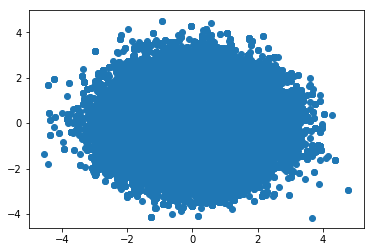

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=2)

x_std = StandardScaler().fit_transform(np.vstack(chains))
x_pca = pca.fit_transform(x_std)

plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.show()

## Tempered

In [107]:
temperature = 0.9
log_pdf_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_pdf)

# Run MCMC on the noisy data
x0 = [np.repeat(0, n)]*3
mcmc = pints.MCMCSampling(log_pdf_t, 3, x0)
mcmc.set_max_iterations(nsamples)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:00.0
1     6       0.5       0.5       0.5        0:00.0
2     9       0.667     0.667     0.667      0:00.0
3     12      0.75      0.75      0.75       0:00.0
20    63      0.952381  0.952381  0.952381   0:00.0
40    123     0.976     0.976     0.976      0:00.1
60    183     0.984     0.967     0.967      0:00.1
80    243     0.975     0.975     0.975      0:00.1
100   303     0.970297  0.980198  0.980198   0:00.1
120   363     0.975     0.983     0.983      0:00.2
140   423     0.972     0.986     0.986      0:00.2
160   483     0.969     0.988     0.988      0:00.2
180   543     0.972     0.989     0.989      0:00.2
Initial phase completed.
200   603     0.975     0.99      0.99       0:00.3
220   663     0.932     0.968     0.968      0:00.3
240   723     0.888     0.909     0.905      0:00.3
260

3040  9123    0.257     0.252     0.237      0:04.3
3060  9183    0.257     0.253     0.236      0:04.3
3080  9243    0.257384  0.253     0.236      0:04.4
3100  9303    0.258     0.252     0.235      0:04.4
3120  9363    0.258571  0.253     0.236      0:04.4
3140  9423    0.259     0.252     0.236      0:04.4
3160  9483    0.259     0.251819  0.236      0:04.5
3180  9543    0.259038  0.251     0.235      0:04.5
3200  9603    0.26      0.25      0.236      0:04.5
3220  9663    0.26      0.25      0.237      0:04.6
3240  9723    0.26      0.249     0.236      0:04.6
3260  9783    0.261     0.24931   0.236      0:04.6
3280  9843    0.26      0.249     0.236      0:04.7
3300  9903    0.261     0.249     0.236595   0:04.7
3320  9963    0.26      0.248     0.236      0:04.7
3340  10023   0.258     0.247     0.236      0:04.7
3360  10083   0.258     0.246     0.237      0:04.8
3380  10143   0.258     0.245     0.237      0:04.8
3400  10203   0.258     0.245222  0.236      0:04.8
3420  10263 

6240  18723   0.24      0.226     0.233      0:08.9
6260  18783   0.24      0.225     0.233      0:08.9
6280  18843   0.24      0.225     0.232      0:09.0
6300  18903   0.24      0.225     0.232      0:09.0
6320  18963   0.24      0.225     0.232      0:09.0
6340  19023   0.239     0.225     0.232      0:09.0
6360  19083   0.239585  0.225     0.232039   0:09.1
6380  19143   0.239     0.225     0.232      0:09.1
6400  19203   0.239     0.225     0.233      0:09.1
6420  19263   0.239     0.224     0.232674   0:09.2
6440  19323   0.239     0.225     0.233      0:09.2
6460  19383   0.238     0.225     0.233      0:09.2
6480  19443   0.238     0.224811  0.233      0:09.2
6500  19503   0.238271  0.225     0.233      0:09.3
6520  19563   0.237847  0.225     0.232      0:09.3
6540  19623   0.238     0.225     0.233      0:09.3
6560  19683   0.237159  0.225     0.232      0:09.4
6580  19743   0.237198  0.225     0.232      0:09.4
6600  19803   0.237     0.225     0.233      0:09.4
6620  19863 

9440  28323   0.225     0.228     0.231      0:13.5
9460  28383   0.225     0.228     0.231      0:13.5
9480  28443   0.225     0.228     0.232      0:13.5
9500  28503   0.225     0.227     0.231      0:13.6
9520  28563   0.225     0.226972  0.231      0:13.6
9540  28623   0.225     0.227     0.231      0:13.6
9560  28683   0.225     0.227     0.231      0:13.6
9580  28743   0.225     0.227     0.232      0:13.7
9600  28803   0.225289  0.227     0.231      0:13.7
9620  28863   0.225     0.226     0.231      0:13.7
9640  28923   0.225     0.226     0.231615   0:13.8
9660  28983   0.225     0.226     0.232      0:13.8
9680  29043   0.225     0.226     0.232414   0:13.8
9700  29103   0.225     0.226     0.232      0:13.8
9720  29163   0.225     0.226     0.232      0:13.9
9740  29223   0.225     0.226     0.232      0:13.9
9760  29283   0.225     0.226     0.231841   0:13.9
9780  29343   0.226     0.227     0.232      0:14.0
9800  29403   0.226     0.227     0.231711   0:14.0
9820  29463 

12640 37923   0.225     0.227     0.232      0:18.0
12660 37983   0.225     0.227     0.233      0:18.1
12680 38043   0.225     0.227348  0.233      0:18.1
12700 38103   0.225     0.228     0.232      0:18.1
12720 38163   0.225     0.227     0.232      0:18.1
12740 38223   0.225     0.227     0.232      0:18.2
12760 38283   0.225     0.22749   0.232      0:18.2
12780 38343   0.225     0.228     0.232      0:18.2
12800 38403   0.225     0.228     0.232      0:18.3
12820 38463   0.225     0.228     0.232      0:18.3
12840 38523   0.225     0.228     0.232147   0:18.3
12860 38583   0.225     0.228     0.231786   0:18.3
12880 38643   0.225     0.227     0.232      0:18.4
12900 38703   0.224     0.227     0.23161    0:18.4
12920 38763   0.224     0.22684   0.231948   0:18.4
12940 38823   0.224     0.227     0.232      0:18.5
12960 38883   0.224     0.22668   0.232      0:18.5
12980 38943   0.224     0.226     0.232      0:18.5
13000 39003   0.224     0.226     0.232      0:18.5
13020 39063 

15840 47523   0.225     0.228     0.23       0:22.6
15860 47583   0.225     0.228     0.23       0:22.6
15880 47643   0.225     0.228     0.23       0:22.6
15900 47703   0.225     0.228036  0.23       0:22.7
15920 47763   0.225     0.228     0.23089    0:22.7
15940 47823   0.225     0.228     0.231      0:22.7
15960 47883   0.225     0.228     0.231      0:22.8
15980 47943   0.225     0.228     0.231      0:22.8
16000 48003   0.225     0.228     0.231      0:22.8
16020 48063   0.225     0.228     0.231      0:22.8
16040 48123   0.225173  0.228     0.231      0:22.9
16060 48183   0.225     0.228317  0.230434   0:22.9
16080 48243   0.225     0.228     0.231      0:22.9
16100 48303   0.225     0.228     0.23       0:23.0
16120 48363   0.225     0.228     0.23       0:23.0
16140 48423   0.225     0.228     0.23       0:23.0
16160 48483   0.225     0.228     0.23       0:23.0
16180 48543   0.225     0.228     0.23       0:23.1
16200 48603   0.225     0.228381  0.23       0:23.1
16220 48663 

19040 57123   0.227     0.229     0.231658   0:27.1
19060 57183   0.227113  0.23      0.231      0:27.2
19080 57243   0.227     0.229     0.232      0:27.2
19100 57303   0.227     0.229     0.232      0:27.2
19120 57363   0.227     0.229     0.231      0:27.3
19140 57423   0.227     0.23      0.232      0:27.3
19160 57483   0.227128  0.23      0.232      0:27.3
19180 57543   0.227     0.229     0.232      0:27.3
19200 57603   0.227     0.23      0.232      0:27.4
19220 57663   0.227     0.23      0.232      0:27.4
19240 57723   0.227     0.23      0.232      0:27.4
19260 57783   0.227     0.23      0.232      0:27.5
19280 57843   0.227     0.23      0.232      0:27.5
19300 57903   0.227     0.23      0.232      0:27.5
19320 57963   0.227     0.23      0.232      0:27.5
19340 58023   0.227     0.23      0.231684   0:27.6
19360 58083   0.227     0.23      0.232      0:27.6
19380 58143   0.227     0.229     0.232      0:27.6
19400 58203   0.226844  0.23      0.231586   0:27.7
19420 58263 

22220 66663   0.228     0.229     0.232      0:31.7
22240 66723   0.228     0.229     0.232      0:31.7
22260 66783   0.228     0.229     0.232      0:31.8
22280 66843   0.228     0.229     0.232      0:31.8
22300 66903   0.228     0.229048  0.232      0:31.8
22320 66963   0.22835   0.229     0.232      0:31.8
22340 67023   0.228     0.229     0.232      0:31.9
22360 67083   0.229     0.229     0.232      0:31.9
22380 67143   0.229     0.229     0.232      0:31.9
22400 67203   0.229     0.229     0.23182    0:32.0
22420 67263   0.229     0.229     0.232      0:32.0
22440 67323   0.229     0.229     0.231585   0:32.0
22460 67383   0.229     0.229     0.232      0:32.0
22480 67443   0.228682  0.229     0.232      0:32.1
22500 67503   0.229     0.229     0.232      0:32.1
22520 67563   0.229     0.229     0.232      0:32.1
22540 67623   0.229     0.229     0.232      0:32.2
22560 67683   0.228     0.229     0.23155    0:32.2
22580 67743   0.229     0.229     0.232      0:32.2
22600 67803 

25420 76263   0.229     0.23      0.231      0:36.3
25440 76323   0.229     0.23      0.231      0:36.3
25460 76383   0.229     0.23      0.231      0:36.3
25480 76443   0.229     0.23      0.231      0:36.3
25500 76503   0.229     0.23      0.231      0:36.4
25520 76563   0.229     0.23      0.231      0:36.4
25540 76623   0.229     0.23      0.231      0:36.4
25560 76683   0.229     0.23      0.231      0:36.4
25580 76743   0.229     0.23      0.230679   0:36.5
25600 76803   0.229     0.23      0.231      0:36.5
25620 76863   0.229     0.23      0.231      0:36.5
25640 76923   0.229     0.23      0.231      0:36.6
25660 76983   0.229     0.23      0.231      0:36.6
25680 77043   0.229     0.23      0.231      0:36.6
25700 77103   0.229     0.23      0.23       0:36.6
25720 77163   0.229     0.23      0.23       0:36.7
25740 77223   0.229     0.23      0.23       0:36.7
25760 77283   0.228679  0.23      0.23       0:36.7
25780 77343   0.229     0.23      0.230441   0:36.8
25800 77403 

28620 85863   0.229     0.23      0.232277   0:40.8
28640 85923   0.229     0.23      0.232      0:40.8
28660 85983   0.229     0.23      0.232      0:40.9
28680 86043   0.229     0.23      0.232      0:40.9
28700 86103   0.229     0.23      0.232      0:40.9
28720 86163   0.229     0.23      0.232      0:41.0
28740 86223   0.229     0.23      0.232177   0:41.0
28760 86283   0.228782  0.229999  0.232      0:41.0
28780 86343   0.229     0.23      0.232      0:41.0
28800 86403   0.229     0.23      0.232      0:41.1
28820 86463   0.229     0.23      0.232      0:41.1
28840 86523   0.229     0.23      0.232      0:41.1
28860 86583   0.229202  0.229895  0.232      0:41.2
28880 86643   0.229     0.23      0.232      0:41.2
28900 86703   0.229     0.23      0.232      0:41.2
28920 86763   0.229     0.230075  0.232      0:41.2
28940 86823   0.229     0.23      0.232      0:41.3
28960 86883   0.229     0.230068  0.232      0:41.3
28980 86943   0.229     0.23      0.232      0:41.3
29000 87003 

31820 95463   0.229     0.23      0.232488   0:45.4
31840 95523   0.229     0.23      0.232      0:45.4
31860 95583   0.229     0.23      0.232      0:45.4
31880 95643   0.229447  0.23      0.232      0:45.5
31900 95703   0.229     0.23      0.232      0:45.5
31920 95763   0.229     0.23      0.232      0:45.5
31940 95823   0.229     0.230237  0.232      0:45.5
31960 95883   0.229     0.23      0.233      0:45.6
31980 95943   0.22948   0.23      0.232      0:45.6
32000 96003   0.23      0.23      0.232      0:45.6
32020 96063   0.23      0.23      0.232      0:45.7
32040 96123   0.23      0.230205  0.232      0:45.7
32060 96183   0.23      0.23      0.232      0:45.7
32080 96243   0.23      0.23      0.232287   0:45.8
32100 96303   0.23      0.23      0.232      0:45.8
32120 96363   0.23      0.23      0.232      0:45.8
32140 96423   0.23      0.23      0.232      0:45.8
32160 96483   0.23      0.23      0.232      0:45.9
32180 96543   0.229794  0.23      0.232      0:45.9
32200 96603 

35020 105063  0.231     0.231     0.232      0:49.9
35040 105123  0.230587  0.231     0.232      0:50.0
35060 105183  0.231     0.231     0.232      0:50.0
35080 105243  0.231     0.231     0.232234   0:50.0
35100 105303  0.231     0.231     0.232      0:50.1
35120 105363  0.23      0.231     0.232      0:50.1
35140 105423  0.23      0.231     0.232      0:50.1
35160 105483  0.23      0.231     0.232      0:50.1
35180 105543  0.23      0.231     0.232      0:50.2
35200 105603  0.231     0.231     0.232      0:50.2
35220 105663  0.231     0.231     0.232      0:50.2
35240 105723  0.23      0.230754  0.232      0:50.2
35260 105783  0.23      0.231     0.232      0:50.3
35280 105843  0.231     0.231     0.232      0:50.3
35300 105903  0.23056   0.231     0.232      0:50.3
35320 105963  0.231     0.231     0.232      0:50.4
35340 106023  0.23      0.231     0.232      0:50.4
35360 106083  0.231     0.231     0.232      0:50.4
35380 106143  0.23      0.231     0.232      0:50.5
35400 106203

38220 114663  0.231     0.231     0.233      0:54.5
38240 114723  0.231     0.231     0.233      0:54.5
38260 114783  0.231     0.231     0.233      0:54.6
38280 114843  0.231     0.231     0.233      0:54.6
38300 114903  0.23      0.231     0.233      0:54.6
38320 114963  0.230422  0.231     0.233      0:54.6
38340 115023  0.23      0.231     0.233      0:54.7
38360 115083  0.230312  0.231     0.233      0:54.7
38380 115143  0.23      0.231     0.233      0:54.7
38400 115203  0.23      0.231     0.233      0:54.8
38420 115263  0.23      0.231     0.233      0:54.8
38440 115323  0.230301  0.231     0.233      0:54.8
38460 115383  0.23      0.231     0.233      0:54.8
38480 115443  0.23      0.231     0.233      0:54.9
38500 115503  0.23      0.230981  0.232903   0:54.9
38520 115563  0.23      0.231     0.232886   0:54.9
38540 115623  0.23      0.231     0.233      0:55.0
38560 115683  0.23      0.231     0.233      0:55.0
38580 115743  0.23      0.231     0.233      0:55.0
38600 115803

41420 124263  0.23      0.231     0.232      0:59.1
41440 124323  0.23      0.231     0.232      0:59.1
41460 124383  0.23      0.231     0.232      0:59.1
41480 124443  0.23      0.231     0.232      0:59.1
41500 124503  0.23      0.231     0.232      0:59.2
41520 124563  0.23      0.231     0.232      0:59.2
41540 124623  0.23      0.231     0.232      0:59.2
41560 124683  0.23      0.231     0.232      0:59.3
41580 124743  0.23      0.231019  0.232      0:59.3
41600 124803  0.23      0.231     0.232254   0:59.3
41620 124863  0.23      0.231     0.232      0:59.3
41640 124923  0.23      0.231     0.232199   0:59.4
41660 124983  0.23      0.231     0.232      0:59.4
41680 125043  0.23      0.231     0.232      0:59.4
41700 125103  0.23      0.231     0.232      0:59.5
41720 125163  0.23      0.231     0.232      0:59.5
41740 125223  0.23      0.231     0.232      0:59.5
41760 125283  0.23      0.231     0.232      0:59.5
41780 125343  0.23      0.231     0.232      0:59.6
41800 125403

44620 133863  0.23      0.23      0.232      1:03.6
44640 133923  0.23      0.23      0.232      1:03.6
44660 133983  0.230268  0.23      0.232      1:03.7
44680 134043  0.23      0.23      0.232      1:03.7
44700 134103  0.23      0.23      0.232      1:03.7
44720 134163  0.23      0.23      0.232      1:03.7
44740 134223  0.23      0.23      0.232      1:03.8
44760 134283  0.23      0.23      0.231876   1:03.8
44780 134343  0.23      0.23      0.232      1:03.8
44800 134403  0.23      0.23      0.232      1:03.9
44820 134463  0.23016   0.23      0.232      1:03.9
44840 134523  0.23      0.23      0.232      1:03.9
44860 134583  0.23      0.2302    0.232      1:03.9
44880 134643  0.23      0.23      0.232      1:04.0
44900 134703  0.23      0.23      0.232      1:04.0
44920 134763  0.23      0.23      0.232      1:04.0
44940 134823  0.23      0.23      0.232      1:04.1
44960 134883  0.23      0.23      0.232      1:04.1
44980 134943  0.23      0.23      0.232      1:04.1
45000 135003

47820 143463  0.23      0.231     0.233      1:08.1
47840 143523  0.2302    0.231     0.233      1:08.2
47860 143583  0.23      0.231     0.233      1:08.2
47880 143643  0.23      0.231     0.233      1:08.2
47900 143703  0.23      0.231     0.233      1:08.3
47920 143763  0.230254  0.231     0.233      1:08.3
47940 143823  0.23      0.231     0.233      1:08.3
47960 143883  0.23      0.231     0.232981   1:08.3
47980 143943  0.23      0.231     0.233      1:08.4
48000 144003  0.23      0.231     0.233      1:08.4
48020 144063  0.23      0.231     0.233      1:08.4
48040 144123  0.23      0.231     0.233      1:08.5
48060 144183  0.23      0.231     0.233      1:08.5
48080 144243  0.23      0.231     0.233      1:08.5
48100 144303  0.23      0.231     0.233      1:08.5
48120 144363  0.23      0.231     0.232809   1:08.6
48140 144423  0.23      0.231     0.232733   1:08.6
48160 144483  0.23      0.231     0.233      1:08.6
48180 144543  0.23      0.231     0.233      1:08.7
48200 144603

51020 153063  0.231     0.231     0.232      1:12.7
51040 153123  0.231     0.231     0.232      1:12.7
51060 153183  0.231     0.230489  0.233      1:12.8
51080 153243  0.231     0.231     0.233      1:12.8
51100 153303  0.231     0.231     0.233      1:12.8
51120 153363  0.231     0.231     0.232605   1:12.9
51140 153423  0.231     0.231     0.233      1:12.9
51160 153483  0.230879  0.231     0.233      1:12.9
51180 153543  0.231     0.231     0.233      1:12.9
51200 153603  0.231     0.231     0.233      1:13.0
51220 153663  0.231     0.23      0.233      1:13.0
51240 153723  0.231     0.23      0.233      1:13.0
51260 153783  0.231     0.23      0.232555   1:13.1
51280 153843  0.231     0.23      0.233      1:13.1
51300 153903  0.231     0.23      0.233      1:13.1
51320 153963  0.231     0.23      0.233      1:13.1
51340 154023  0.231     0.23      0.233      1:13.2
51360 154083  0.231     0.23      0.233      1:13.2
51380 154143  0.231     0.23      0.233      1:13.2
51400 154203

54220 162663  0.23      0.231     0.233      1:17.3
54240 162723  0.23      0.231     0.233      1:17.3
54260 162783  0.23      0.231     0.233      1:17.3
54280 162843  0.23      0.231     0.233      1:17.4
54300 162903  0.23      0.231     0.233      1:17.4
54320 162963  0.23      0.230537  0.233      1:17.4
54340 163023  0.23      0.231     0.233      1:17.4
54360 163083  0.230349  0.231     0.233      1:17.5
54380 163143  0.23      0.231     0.233      1:17.5
54400 163203  0.23      0.231     0.233      1:17.5
54420 163263  0.23      0.231     0.233      1:17.6
54440 163323  0.23      0.231     0.233      1:17.6
54460 163383  0.23033   0.231     0.233      1:17.6
54480 163443  0.23      0.231     0.233      1:17.6
54500 163503  0.23      0.231     0.233      1:17.7
54520 163563  0.23      0.231     0.233      1:17.7
54540 163623  0.23      0.231     0.233      1:17.7
54560 163683  0.230421  0.231     0.232602   1:17.8
54580 163743  0.23      0.231     0.233      1:17.8
54600 163803

57420 172263  0.23      0.232     0.233      1:21.9
57440 172323  0.23      0.232     0.233      1:21.9
57460 172383  0.230452  0.231531  0.233      1:21.9
57480 172443  0.23      0.232     0.233      1:21.9
57500 172503  0.23      0.232     0.233      1:22.0
57520 172563  0.23      0.232     0.232      1:22.0
57540 172623  0.23      0.231     0.232      1:22.0
57560 172683  0.23      0.232     0.232      1:22.0
57580 172743  0.230458  0.232     0.232      1:22.1
57600 172803  0.23      0.232     0.233      1:22.1
57620 172863  0.23      0.232     0.233      1:22.1
57640 172923  0.23      0.232     0.233      1:22.2
57660 172983  0.23      0.231543  0.233      1:22.2
57680 173043  0.23      0.231     0.233      1:22.2
57700 173103  0.230412  0.231     0.233      1:22.3
57720 173163  0.23      0.231     0.232619   1:22.3
57740 173223  0.23      0.231     0.232625   1:22.3
57760 173283  0.23      0.231     0.233      1:22.3
57780 173343  0.23      0.231339  0.233      1:22.4
57800 173403

60620 181863  0.231075  0.232     0.232      1:26.4
60640 181923  0.231     0.232     0.232      1:26.4
60660 181983  0.231     0.232     0.232      1:26.5
60680 182043  0.231     0.232     0.232      1:26.5
60700 182103  0.231     0.231726  0.232      1:26.5
60720 182163  0.231     0.232     0.232012   1:26.6
60740 182223  0.231     0.232     0.232      1:26.6
60760 182283  0.231     0.231744  0.232      1:26.6
60780 182343  0.231     0.232     0.232      1:26.6
60800 182403  0.231     0.232     0.232      1:26.7
60820 182463  0.231     0.232     0.232      1:26.7
60840 182523  0.231     0.232     0.232      1:26.7
60860 182583  0.231     0.232     0.232      1:26.8
60880 182643  0.231353  0.232     0.23201    1:26.8
60900 182703  0.231     0.232     0.232      1:26.8
60920 182763  0.231398  0.232     0.231989   1:26.8
60940 182823  0.231437  0.232     0.232      1:26.9
60960 182883  0.231     0.232     0.231968   1:26.9
60980 182943  0.231     0.232     0.232      1:26.9
61000 183003

63820 191463  0.231     0.232     0.2324     1:31.0
63840 191523  0.231     0.232     0.232      1:31.0
63860 191583  0.231     0.232     0.232      1:31.1
63880 191643  0.231446  0.232     0.233      1:31.1
63900 191703  0.231     0.232     0.233      1:31.1
63920 191763  0.231     0.232     0.233      1:31.1
63940 191823  0.231     0.232     0.232      1:31.2
63960 191883  0.231     0.232     0.233      1:31.2
63980 191943  0.231475  0.232     0.233      1:31.2
64000 192003  0.231512  0.232387  0.233      1:31.2
64020 192063  0.232     0.232     0.232      1:31.3
64040 192123  0.232     0.232     0.232      1:31.3
64060 192183  0.232     0.232     0.232      1:31.3
64080 192243  0.232     0.232     0.232409   1:31.4
64100 192303  0.231     0.232     0.232      1:31.4
64120 192363  0.232     0.232     0.232      1:31.4
64140 192423  0.232     0.232     0.232      1:31.5
64160 192483  0.232     0.232     0.232      1:31.5
64180 192543  0.232     0.232     0.232      1:31.5
64200 192603

67020 201063  0.231     0.232     0.232      1:35.6
67040 201123  0.231     0.232     0.232      1:35.6
67060 201183  0.231     0.232     0.232296   1:35.6
67080 201243  0.231     0.232     0.232      1:35.6
67100 201303  0.231     0.232     0.232      1:35.7
67120 201363  0.231     0.232     0.232      1:35.7
67140 201423  0.231     0.232     0.232      1:35.7
67160 201483  0.231     0.232     0.232      1:35.7
67180 201543  0.231     0.232     0.232      1:35.8
67200 201603  0.231     0.232318  0.232      1:35.8
67220 201663  0.231     0.232     0.232      1:35.8
67240 201723  0.231     0.232     0.232      1:35.9
67260 201783  0.231     0.232304  0.232304   1:35.9
67280 201843  0.231     0.232     0.232      1:35.9
67300 201903  0.231     0.232     0.232      1:35.9
67320 201963  0.231     0.232     0.232      1:36.0
67340 202023  0.231     0.232     0.233      1:36.0
67360 202083  0.231     0.232     0.233      1:36.0
67380 202143  0.231     0.232     0.233      1:36.1
67400 202203

70220 210663  0.232     0.232     0.23258    1:40.1
70240 210723  0.232     0.232     0.233      1:40.1
70260 210783  0.231679  0.232     0.233      1:40.2
70280 210843  0.232     0.232     0.233      1:40.2
70300 210903  0.232     0.232358  0.233      1:40.2
70320 210963  0.231652  0.232     0.233      1:40.2
70340 211023  0.232     0.232     0.233      1:40.3
70360 211083  0.231634  0.232     0.232501   1:40.3
70380 211143  0.232     0.232     0.232      1:40.3
70400 211203  0.232     0.232     0.232      1:40.4
70420 211263  0.232     0.232     0.232      1:40.4
70440 211323  0.232     0.232     0.232      1:40.4
70460 211383  0.232     0.232     0.232      1:40.4
70480 211443  0.231722  0.232     0.232      1:40.5
70500 211503  0.232     0.232479  0.233      1:40.5
70520 211563  0.232     0.232     0.233      1:40.5
70540 211623  0.232     0.232     0.233      1:40.6
70560 211683  0.232     0.232     0.233      1:40.6
70580 211743  0.232     0.232     0.233      1:40.6
70600 211803

73420 220263  0.232     0.232     0.232      1:44.7
73440 220323  0.232     0.232377  0.232      1:44.7
73460 220383  0.232     0.232     0.232      1:44.7
73480 220443  0.231815  0.232373  0.232      1:44.7
73500 220503  0.232     0.232     0.232      1:44.8
73520 220563  0.232     0.232     0.232      1:44.8
73540 220623  0.232     0.232     0.232      1:44.8
73560 220683  0.232     0.232     0.232      1:44.9
73580 220743  0.232     0.232     0.232      1:44.9
73600 220803  0.232     0.232     0.232      1:44.9
73620 220863  0.232     0.232     0.232      1:44.9
73640 220923  0.232     0.232     0.232      1:45.0
73660 220983  0.232     0.232     0.232      1:45.0
73680 221043  0.232     0.232     0.232      1:45.0
73700 221103  0.232     0.232     0.232412   1:45.1
73720 221163  0.232     0.232     0.232      1:45.1
73740 221223  0.23173   0.232     0.232      1:45.1
73760 221283  0.232     0.232     0.232      1:45.1
73780 221343  0.232     0.232     0.232      1:45.2
73800 221403

76620 229863  0.232     0.232     0.232      1:49.2
76640 229923  0.232     0.232     0.232      1:49.3
76660 229983  0.232     0.232     0.232      1:49.3
76680 230043  0.232     0.232     0.232      1:49.3
76700 230103  0.232     0.232     0.232      1:49.3
76720 230163  0.232     0.232     0.232      1:49.4
76740 230223  0.232     0.232379  0.232      1:49.4
76760 230283  0.232     0.232     0.232      1:49.4
76780 230343  0.232     0.232     0.232      1:49.5
76800 230403  0.232     0.232     0.232      1:49.5
76820 230463  0.232     0.232     0.232      1:49.5
76840 230523  0.232     0.232     0.232389   1:49.5
76860 230583  0.232     0.232     0.232      1:49.6
76880 230643  0.232     0.232     0.232      1:49.6
76900 230703  0.232     0.232     0.232      1:49.6
76920 230763  0.232     0.232     0.232      1:49.7
76940 230823  0.231905  0.232     0.233      1:49.7
76960 230883  0.232     0.232     0.233      1:49.7
76980 230943  0.232     0.232421  0.233      1:49.7
77000 231003

79820 239463  0.232     0.232     0.233      1:53.8
79840 239523  0.232     0.232     0.232938   1:53.8
79860 239583  0.231953  0.232     0.233      1:53.8
79880 239643  0.232     0.232     0.232934   1:53.8
79900 239703  0.231937  0.232     0.233      1:53.9
79920 239763  0.232     0.231854  0.23293    1:53.9
79940 239823  0.232     0.232     0.233      1:53.9
79960 239883  0.232     0.232     0.233      1:54.0
79980 239943  0.232     0.232     0.233      1:54.0
80000 240003  0.232     0.232     0.233      1:54.0
80020 240063  0.232     0.232     0.233      1:54.0
80040 240123  0.232     0.232     0.233      1:54.1
80060 240183  0.232     0.232     0.233      1:54.1
80080 240243  0.232     0.232     0.233      1:54.1
80100 240303  0.232     0.232     0.233      1:54.2
80120 240363  0.232     0.231762  0.233035   1:54.2
80140 240423  0.232     0.231779  0.233      1:54.2
80160 240483  0.232     0.232     0.233      1:54.2
80180 240543  0.231838  0.232     0.233      1:54.3
80200 240603

83020 249063  0.232     0.232     0.233      1:58.3
83040 249123  0.232     0.232     0.233      1:58.4
83060 249183  0.232     0.232     0.233      1:58.4
83080 249243  0.232     0.232     0.233      1:58.4
83100 249303  0.232     0.232     0.233      1:58.4
83120 249363  0.232     0.231963  0.233      1:58.5
83140 249423  0.232     0.232     0.233      1:58.5
83160 249483  0.232     0.232     0.233      1:58.5
83180 249543  0.232     0.231928  0.233      1:58.6
83200 249603  0.232     0.232     0.233      1:58.6
83220 249663  0.232     0.232     0.233      1:58.6
83240 249723  0.231941  0.232     0.233      1:58.6
83260 249783  0.232     0.232     0.233      1:58.7
83280 249843  0.232     0.232     0.233      1:58.7
83300 249903  0.232     0.231882  0.233      1:58.7
83320 249963  0.232     0.232     0.233      1:58.8
83340 250023  0.232     0.232     0.233      1:58.8
83360 250083  0.231823  0.231847  0.233      1:58.8
83380 250143  0.232     0.232     0.233      1:58.8
83400 250203

86220 258663  0.232     0.232     0.233203   2:02.9
86240 258723  0.232     0.232     0.233      2:02.9
86260 258783  0.232     0.232     0.233      2:02.9
86280 258843  0.232     0.232415  0.233      2:03.0
86300 258903  0.231805  0.232     0.233      2:03.0
86320 258963  0.232     0.232     0.233      2:03.0
86340 259023  0.232     0.232     0.233      2:03.1
86360 259083  0.232     0.232     0.233      2:03.1
86380 259143  0.232     0.232447  0.233      2:03.1
86400 259203  0.232     0.232     0.233      2:03.1
86420 259263  0.232     0.232     0.233      2:03.2
86440 259323  0.232     0.232     0.233107   2:03.2
86460 259383  0.231723  0.232     0.233      2:03.2
86480 259443  0.231785  0.233     0.233057   2:03.3
86500 259503  0.232     0.232506  0.233      2:03.3
86520 259563  0.232     0.232     0.233      2:03.3
86540 259623  0.232     0.232     0.233      2:03.3
86560 259683  0.232     0.232     0.233      2:03.4
86580 259743  0.232     0.232     0.233      2:03.4
86600 259803

89400 268203  0.232201  0.232     0.233      2:07.4
89420 268263  0.232     0.232     0.233      2:07.4
89440 268323  0.232276  0.232     0.233      2:07.5
89460 268383  0.23228   0.232     0.233      2:07.5
89480 268443  0.232     0.232     0.233      2:07.5
89500 268503  0.232     0.232     0.233      2:07.6
89520 268563  0.232     0.232     0.233      2:07.6
89540 268623  0.232     0.232441  0.233      2:07.6
89560 268683  0.232     0.232     0.233      2:07.6
89580 268743  0.232     0.232     0.233      2:07.7
89600 268803  0.232     0.232     0.233167   2:07.7
89620 268863  0.232     0.232     0.233      2:07.7
89640 268923  0.232     0.232     0.233      2:07.7
89660 268983  0.232     0.232     0.233      2:07.8
89680 269043  0.232     0.232435  0.233      2:07.8
89700 269103  0.232     0.232     0.233      2:07.8
89720 269163  0.232     0.232     0.233      2:07.9
89740 269223  0.232313  0.232     0.233      2:07.9
89760 269283  0.232     0.232     0.233      2:07.9
89780 269343

92600 277803  0.232     0.232     0.233      2:12.0
92620 277863  0.232     0.232     0.233      2:12.0
92640 277923  0.232     0.232     0.233      2:12.0
92660 277983  0.232266  0.232     0.233      2:12.1
92680 278043  0.232     0.232     0.233      2:12.1
92700 278103  0.232     0.23195   0.233      2:12.1
92720 278163  0.232299  0.232     0.233      2:12.1
92740 278223  0.232     0.232     0.233      2:12.2
92760 278283  0.232     0.232     0.233      2:12.2
92780 278343  0.232     0.232     0.233      2:12.2
92800 278403  0.232     0.232     0.233      2:12.3
92820 278463  0.232     0.232     0.233      2:12.3
92840 278523  0.232     0.232     0.233      2:12.3
92860 278583  0.232     0.232     0.233      2:12.3
92880 278643  0.232     0.232125  0.233      2:12.4
92900 278703  0.232     0.232     0.233      2:12.4
92920 278763  0.232     0.232     0.233      2:12.4
92940 278823  0.232     0.232     0.233      2:12.5
92960 278883  0.232     0.232     0.233      2:12.5
92980 278943

95800 287403  0.232     0.232     0.232388   2:16.5
95820 287463  0.232     0.232     0.232      2:16.5
95840 287523  0.232291  0.232     0.232      2:16.6
95860 287583  0.232     0.232     0.232      2:16.6
95880 287643  0.232     0.232     0.232      2:16.6
95900 287703  0.232     0.232     0.232      2:16.7
95920 287763  0.232     0.232483  0.232      2:16.7
95940 287823  0.232     0.232     0.232      2:16.7
95960 287883  0.232     0.233     0.232      2:16.7
95980 287943  0.232     0.233     0.232      2:16.8
96000 288003  0.232     0.233     0.232      2:16.8
96020 288063  0.232     0.233     0.232      2:16.8
96040 288123  0.232255  0.233     0.232432   2:16.9
96060 288183  0.232     0.233     0.232      2:16.9
96080 288243  0.232     0.232637  0.232      2:16.9
96100 288303  0.232     0.233     0.232      2:16.9
96120 288363  0.232     0.233     0.232      2:17.0
96140 288423  0.232     0.233     0.232      2:17.0
96160 288483  0.232     0.233     0.232      2:17.0
96180 288543

99000 297003  0.232     0.233     0.232      2:21.1
99020 297063  0.232     0.233     0.232      2:21.1
99040 297123  0.232     0.233     0.232      2:21.1
99060 297183  0.232     0.232695  0.232059   2:21.2
99080 297243  0.232103  0.233     0.232      2:21.2
99100 297303  0.232     0.233     0.232      2:21.2
99120 297363  0.232     0.233     0.232      2:21.2
99140 297423  0.232     0.233     0.232      2:21.3
99160 297483  0.232067  0.233     0.232057   2:21.3
99180 297543  0.232     0.233     0.232      2:21.3
99200 297603  0.232     0.233     0.232      2:21.3
99220 297663  0.232088  0.233     0.232      2:21.4
99240 297723  0.232     0.233     0.232      2:21.4
99260 297783  0.232065  0.233     0.232      2:21.4
99280 297843  0.232     0.233     0.232      2:21.5
99300 297903  0.232052  0.233     0.232052   2:21.5
99320 297963  0.232     0.2327    0.232      2:21.5
99340 298023  0.232     0.233     0.232      2:21.6
99360 298083  0.232     0.233     0.232      2:21.6
99380 298143

### Raw samples (before importance sampling)

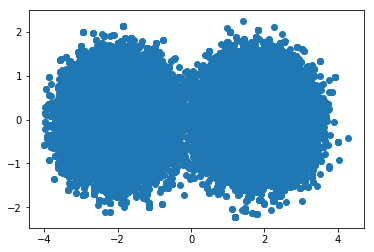

In [108]:
pca = decomposition.PCA(n_components=2)

x_std = StandardScaler().fit_transform(np.vstack(chains))
x_pca = pca.fit_transform(x_std)

plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.show()

### Plot samples over time for one dimension

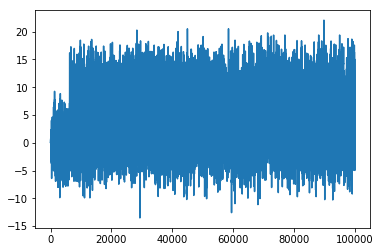

In [109]:
plt.plot(chains[0][:, 0])
plt.show()

ESS = 4712


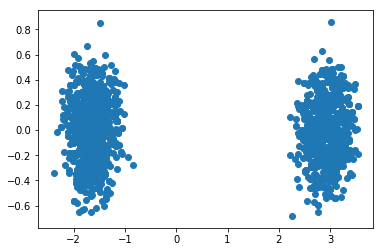

In [110]:
samples = np.vstack(chains)
log_weight = [temperature * log_pdf(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))

print('ESS = ' + str(ess(w)))

idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

x_std = StandardScaler().fit_transform(samples1)
x_pca = pca.fit_transform(x_std)

plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.show()

In [17]:
import numpy as np
x=10
fx = np.array([3, 4, 11])
accepted = [a < x for a in fx]

In [18]:
[fx[c] for c, x in enumerate(accepted) if x]

[3, 4]

In [19]:
len(None)

TypeError: object of type 'NoneType' has no len()